In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
cwdir = 'D:\\project\\봄가을 전처리\\보낼파일\\봄가을 자동 완성'
import sys
sys.path.append(cwdir)
sys.path.append(cwdir + '\\module')
import table as tb
import model_library as lib
import ClusterAnalysis as ca
import math
import shutil
from sklearn.cluster import KMeans
from sklearn.metrics import *
from distutils.dir_util import copy_tree
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import ㄴsilhouette_score
from sklearn.metrics import pairwise_distances
from validclust import dunn
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import k_means
from sklearn import metrics
import matplotlib.cm as cm
import numpy as np

from sklearn.cluster import KMeans
from sklearn.cluster import k_means
from sklearn.metrics import silhouette_samples, silhouette_score

In [6]:

def read_excel(excel) :
	df = pd.read_excel(excel)
	if 'Unnamed: 0' in df.columns :
		df.drop('Unnamed: 0', axis = 1, inplace = True)

	if 'Unnamed: 0.1' in df.columns :
		df.drop('Unnamed: 0.1', axis = 1, inplace = True)

	return df
		
def newfolder(directory):
	try:
		if not os.path.exists(directory):
			os.makedirs(directory)
	except OSError:
		print ('Error: Creating directory. ' +  directory)


def newfolderlist(directory, folderlist):
	for i, names in enumerate(folderlist):
		directory_temp = directory + '\\' + names
		try:
			if not os.path.exists(directory_temp):
				os.makedirs(directory_temp)
		except OSError:
			print ('Error: Creating directory. ' +  directory_temp)

def copyfile(src_dir, dst_dir, src_file) :
	src = src_dir + '\\' + src_file
	dst = dst_dir
	shutil.copyfile(src, dst)

def remove(path):
	# """ param <path> could either be relative or absolute. """
	if os.path.isfile(path) or os.path.islink(path):
		os.remove(path)  # remove the file

	elif os.path.isdir(path):
		shutil.rmtree(path)  # remove dir and all contains
		
	else:
		raise ValueError("file {} is not a file or dir.".format(path))


def all_score(X, num_clusters) :
    
    X_num = []
    for i in range(len(X)) :
        X_num.append(str(i + 1))
    
    cluster_df = pd.DataFrame(columns = ['num_clusters', 'labels', 'dist'])
    cluster_num = 0
    
    for num in num_clusters :
        _, cluster_labels, _ = k_means(X, n_clusters = num)
        dist = pairwise_distances(X)
#         cluster = KMeans(n_clusters = num)
#         cluster_labels = cluster.fit_predict(X)
        
        cluster_df.loc[cluster_num, 'num_clusters'] = num
        cluster_df.loc[cluster_num, 'labels'] = cluster_labels
        cluster_df.loc[cluster_num, 'dist'] = dist
        cluster_num += 1
    
    cluster_df.reset_index(drop = True, inplace = True)
    
    all_score_df = pd.DataFrame(columns = ['num_clusters', 'silhouette_score', 'dunn index', \
                                           'calinski_harabasz_score','davies_bouldin_score'])
    all_score_num = 0
    dist = pairwise_distances(X)
    
    for i in range(len(num_clusters)) :
        all_score_df.loc[all_score_num, 'num_clusters'] = cluster_df.loc[i, 'num_clusters']
        temp_label = cluster_df.loc[i, 'labels']
        temp_dist = cluster_df.loc[i, 'dist']
    
        all_score_df.loc[all_score_num, 'silhouette_score'] = silhouette_score(X, temp_label)
        all_score_df.loc[all_score_num, 'dunn index'] = dunn(temp_dist, temp_label)
        all_score_df.loc[all_score_num, 'calinski_harabasz_score'] = \
                                                metrics.calinski_harabasz_score(X, temp_label)
        all_score_df.loc[all_score_num, 'davies_bouldin_score'] = \
                                                davies_bouldin_score(X, temp_label)
        
        all_score_num += 1
        
    all_score_df.reset_index(drop = True, inplace = True)
        
    
    return cluster_df, all_score_df


def all_score_plot(X, all_score_df, plot) :
    
    max_silh = max(all_score_df.loc[:, 'silhouette_score'])
    max_dunn = max(all_score_df.loc[:, 'dunn index'])
    max_chscore = max(all_score_df.loc[:, 'calinski_harabasz_score'])
    max_dbi = max(all_score_df.loc[:, 'davies_bouldin_score'])
    min_dbi = min(all_score_df.loc[:, 'davies_bouldin_score'])
    
    mp_silh = 0
    mp_dunn = 0
    mp_chscore = 0
    mp_dbi = 0
    minp_dbi = 0
    
    for i in range(all_score_df.shape[0]) :
        if all_score_df.loc[i, 'silhouette_score'] == max_silh :
            mp_silh = all_score_df.loc[i, 'num_clusters']
            
        if all_score_df.loc[i, 'dunn index'] == max_dunn :
            mp_dunn = all_score_df.loc[i, 'num_clusters']
            
        if all_score_df.loc[i, 'calinski_harabasz_score'] == max_chscore :
            mp_chscore = all_score_df.loc[i, 'num_clusters']
            
        if all_score_df.loc[i, 'davies_bouldin_score'] == max_dbi :
            mp_dbi = all_score_df.loc[i, 'num_clusters']
        
        if all_score_df.loc[i, 'davies_bouldin_score'] == min_dbi :
            minp_dbi = all_score_df.loc[i, 'num_clusters']
    
    
    for i in range(all_score_df.shape[0]) :
        all_score_df.loc[i, 'silhouette_score'] = all_score_df.loc[i, 'silhouette_score'] / max_silh
        all_score_df.loc[i, 'dunn index'] = all_score_df.loc[i, 'dunn index'] / max_dunn
        all_score_df.loc[i, 'calinski_harabasz_score'] = all_score_df.loc[i, 'calinski_harabasz_score'] / max_chscore
        all_score_df.loc[i, 'davies_bouldin_score'] = all_score_df.loc[i, 'davies_bouldin_score'] / max_dbi
    
    
    if plot == 1 :
        
        # plot Profiles
        plt.rcParams["figure.figsize"] = (12, 5)
        if X.shape[1] == 2 :
            for i in range(X.shape[0]) :
                plt.plot(X[i][0], X[i][1], c = 'r', marker = 'o')
            plt.title('samples')
            plt.show()
            
        else :
            hours_ex = []
            for i in range(1, X.shape[1] + 1) :
                hours_ex.append(i)
            
            for i in range(X.shape[0]) :
                plt.plot(hours_ex, X[i])
            
            plt.xlim(1, X.shape[1])
            plt.xlabel('hours')
            plt.ylabel('KWh')
            plt.title('random profiles')
            plt.show()

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        plt.rcParams["figure.figsize"] = (12, 5)
        xvalues = all_score_df.loc[:, 'num_clusters'].astype(int)

        y_silh = all_score_df.loc[:, 'silhouette_score']
        y_dunn = all_score_df.loc[:, 'dunn index']
        y_chscore = all_score_df.loc[:, 'calinski_harabasz_score']
        y_dbi = all_score_df.loc[:, 'davies_bouldin_score']

        plt.plot(xvalues, y_silh, label = 'Silhouette score', c = 'b')
        plt.plot(xvalues, y_dunn, label = "Dunn's index", c = 'orange')
        plt.plot(xvalues, y_chscore, label = 'Calinski Harabasz score', c = 'r')
        plt.plot(xvalues, y_dbi, label = 'Davies Bouldin score', c = 'green')

    #     plt.axvline(x = mp_silh, c = 'b', alpha = 0.5)
    #     plt.axvline(x = mp_dunn, c = 'orange', alpha = 0.5)
    #     plt.axvline(x = mp_chscore, c = 'r', alpha = 0.5)
    #     plt.axvline(x = mp_dbi, c = 'green', alpha = 0.5)

        plt.xlim(min(all_score_df.loc[:, 'num_clusters']), max(all_score_df.loc[:, 'num_clusters']))
        major_ticks = xvalues.astype(int)
        ax.set_xticks(major_ticks)

        plt.xlabel('number of clusters')
        plt.ylabel('score (normalized)')
        plt.grid(True, axis='x', color='black', alpha = 0.5, linestyle='--')
        plt.legend()
        plt.show()
    
    
    df_optimal = pd.DataFrame(columns = ['silhouette_score', 'dunn index', 'calinski_harabasz_score', 'davies_bouldin_score'])
    df_optimal.loc[0, :] = [mp_silh, mp_dunn, mp_chscore, minp_dbi]
    df_optimal.loc[1, :] = [max_silh, max_dunn, max_chscore, min_dbi]
    df_optimal.index = ['optimal_K', 'score']
    
    
    return df_optimal

def all_score_set(X, num_clusters, plot) :
    cluster_df, all_score_df = all_score(X, num_clusters)
    df_maxval = all_score_plot(X, all_score_df, plot)
    
    return cluster_df, all_score_df, df_maxval
    

def chs_find(profile, plot) :
    if profile.shape[0] < 13 :
        num_clusters = range(2, profile.shape[0] - 1)
    else :
        num_clusters = range(2, 14)

    X = np.array(profile.loc[:, '1' : '48'].copy())
    
    
    clsuter_df, all_score_df, df_optimal = all_score_set(X, num_clusters, plot)
    K = df_optimal.loc['optimal_K', 'calinski_harabasz_score']
    return K
   

def chs_find(profile, plot) :
    if profile.shape[0] < 13 :
        num_clusters = range(2, profile.shape[0] - 1)
    else :
        num_clusters = range(2, 14)

    X = np.array(profile.loc[:, '1' : '48'].copy())
    
    
    clsuter_df, all_score_df, df_optimal = all_score_set(X, num_clusters, plot)
    K = df_optimal.loc['optimal_K', 'calinski_harabasz_score']
    return K


def chs_find_big(profile, plot) :

    num_clusters = range(2, profile.shape[0])

    X = np.array(profile.loc[:, '1' : '48'].copy())
    
    
    clsuter_df, all_score_df, df_optimal = all_score_set(X, num_clusters, plot)
    K = df_optimal.loc['optimal_K', 'calinski_harabasz_score']
    return K
    
def wanted_centers_plot(info, wanted) :
    for i in range(info.shape[0]) :
        if info.loc[i, 'label'] in wanted :
            plt.plot(range(1, 49), info.loc[i, '1' : '48'])
    plt.show() 

def big_centers_plot(centers) :
    for i in range(centers.shape[0]) :
        if centers.loc[i, 'count'] > 5 :
            alpha_temp = 1
        else :
            alpha_temp = 0
        plt.plot(centers.loc[i, 'center'], label = 'i', alpha = alpha_temp)
    
    plt.show()

def centers_plot(centers) :

    if min(centers.loc[:, 'count'].tolist()) > 5 :
        alpha_rth = 0
    else :
        alpha_rth = 1
    
    if alpha_rth == 0 :
        for i in range(centers.shape[0]) :
            plt.plot(centers.loc[i, 'center'], label = 'i', alpha = 1)

    else :
        for i in range(centers.shape[0]) :
            if centers.loc[i, 'count'] > 5 :
                alpha_temp = 0.3
            else :
                alpha_temp = 1
            plt.plot(centers.loc[i, 'center'], label = 'i', alpha = alpha_temp)
    
    plt.show()
        

In [ ]:
        from matplotlib import gridspec

        maindir = 'D:\\project\\봄가을 전처리\\보낼파일\\봄가을 자동 완성'
        model3dir = maindir + '\\시설군별\\model3'
        model3cluster = maindir + '\\시설군별\\model3_cluster'

        range_n_clusters = [2, 3, 4, 5, 6]
        hours = []
        for i in range(1, 49, 1) :
            hours.append(str(i))

        for folder in os.listdir(model3dir) :
            tempdir = model3dir + '\\' + folder
            os.chdir(tempdir)
            temp = read_excel('profile_48.xlsx')
            temp.columns = temp.columns.astype(str)
            temp.reset_index(drop = True, inplace = True)
            X = temp.loc[:, '1' : '48'].copy()

            for n_clusters in range_n_clusters:
                # Create a subplot with 1 row and 2 columns
        #         fig, (ax1, ax2) = plt.subplots(1, 2)
        #         fig.set_size_inches(20,5)
                fig = plt.figure(figsize = (20, 5))
                gs = gridspec.GridSpec(nrows = 1, ncols = 2, height_ratios = [5], width_ratios = [7, 14])
                ax1 = plt.subplot(gs[0])
                ax2 = plt.subplot(gs[1])
                # The 1st subplot is the silhouette plot
                # The silhouette coefficient can range from -1, 1 but in this example all
                # lie within [-0.1, 1]
                ax1.set_xlim([-0.1, 1])
                # The (n_clusters+1)*10 is for inserting blank space between silhouette
                # plots of individual clusters, to demarcate them clearly.
                ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

                # Initialize the clusterer with n_clusters value and a random generator
                # seed of 10 for reproducibility.
                clusterer = KMeans(n_clusters=n_clusters, random_state=10)
                cluster_labels = clusterer.fit_predict(X)

                # The silhouette_score gives the average value for all the samples.
                # This gives a perspective into the density and separation of the formed
                # clusters
                silhouette_avg = silhouette_score(X, cluster_labels)
                print(
                    "For n_clusters =",
                    n_clusters,
                    "The average silhouette_score is :",
                    silhouette_avg,
                )

                # Compute the silhouette scores for each sample
                sample_silhouette_values = silhouette_samples(X, cluster_labels)

                y_lower = 10
                for i in range(n_clusters):
                    # Aggregate the silhouette scores for samples belonging to
                    # cluster i, and sort them
                    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

                    ith_cluster_silhouette_values.sort()

                    size_cluster_i = ith_cluster_silhouette_values.shape[0]
                    y_upper = y_lower + size_cluster_i

                    color = cm.nipy_spectral(float(i) / n_clusters)
                    ax1.fill_betweenx(
                        np.arange(y_lower, y_upper),
                        0,
                        ith_cluster_silhouette_values,
                        facecolor=color,
                        edgecolor=color,
                        alpha=0.7,
                    )

                    # Label the silhouette plots with their cluster numbers at the middle
                    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                    # Compute the new y_lower for next plot
                    y_lower = y_upper + 10  # 10 for the 0 samples

                ax1.set_title("The silhouette plot for the various clusters.")
                ax1.set_xlabel("The silhouette coefficient values")
                ax1.set_ylabel("Cluster label")

                # The vertical line for average silhouette score of all the values
                ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

                ax1.set_yticks([])  # Clear the yaxis labels / ticks
                ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

                # 2nd Plot showing the actual clusters formed
                colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        #         for i_meters in range(X.shape[0]) :
        #             ax2.plot(hours, X.loc[i_meters, :], alpha = 0.7, c = 'lightgrey')

                # Labeling the clusters
                centers = clusterer.cluster_centers_
                centers_df = pd.DataFrame(centers)
                for i_meters in range(centers.shape[0]) :
                    ax2.plot(hours, centers_df.loc[i_meters, :], alpha = 1, label = '{}th cluster'.format(i_meters))

                # Draw white circles at cluster centers
                ax2.set_title("The visualization of the clustered data.")
                ax2.set_xlabel("hours")
                ax2.set_ylabel(" ")
                ax2.legend()
        #         ax2.xlim(1, 48)
                ax2.plot()
                plt.suptitle(
                    "                  {}, n_cluster = {}".format(folder, n_clusters),
                    fontsize=14,
                    fontweight="bold",
                )
            os.chdir(tempdir)
            plt.savefig('{}_silhouette_method.png'.format(folder), dpi=400)
            plt.show()




['공공행정 국방 및 사회보장 행정', '교육 서비스업', '금융 및 보험업', '도매 및 소매업', '부동산업 및 임대업', '사업시설관리 및 사업지원 서비스업', '숙박 및 음식점업', '예술 스포츠 및 여가관련 서비스업', '전문 과학 및 기술 서비스업', '출판 영상 방송통신 및 정보서비스업']
files all pasted...
ready!


c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


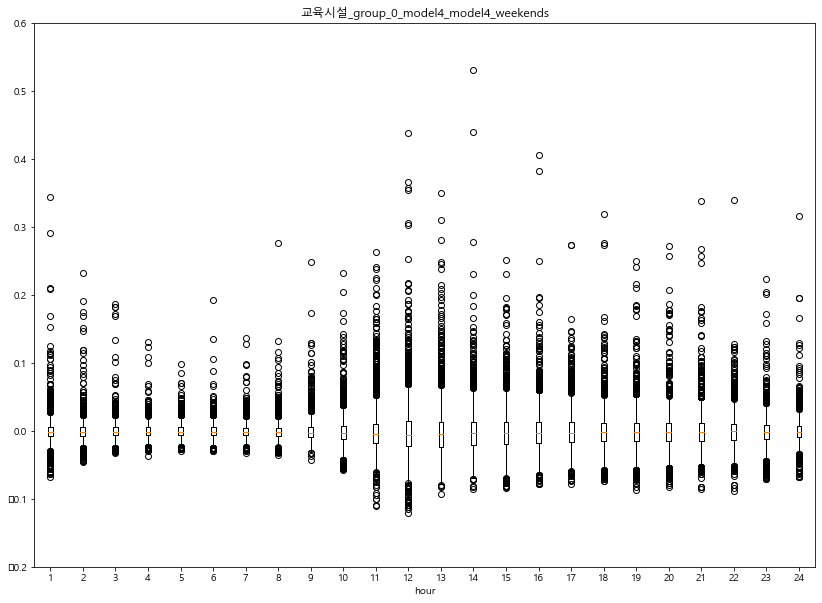

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


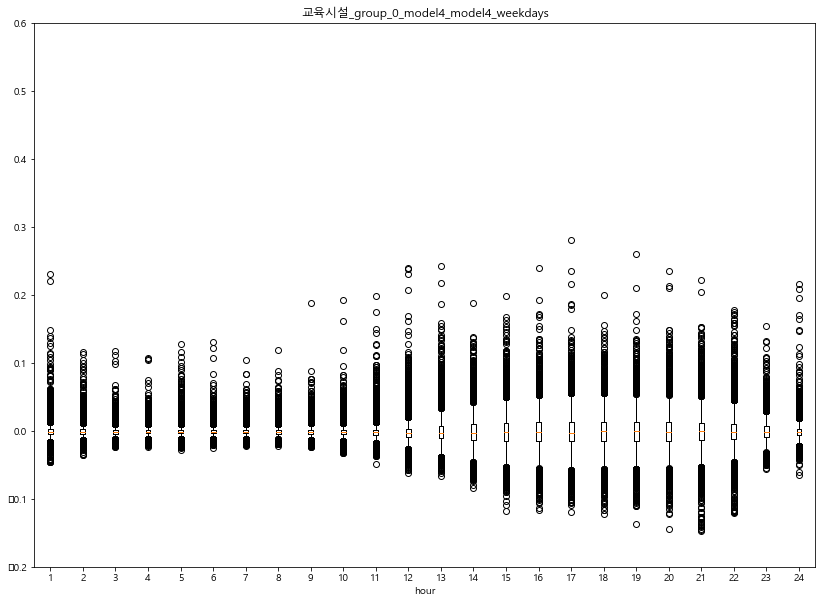

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


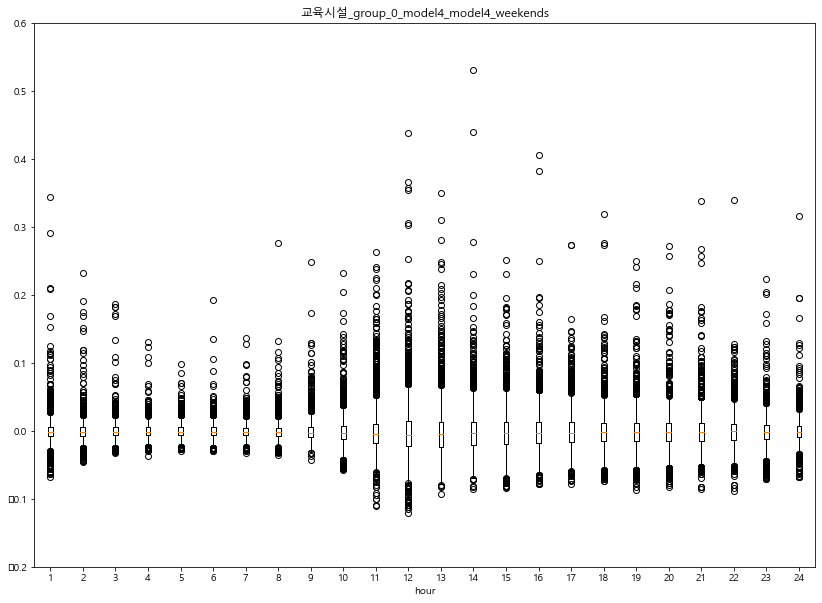

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


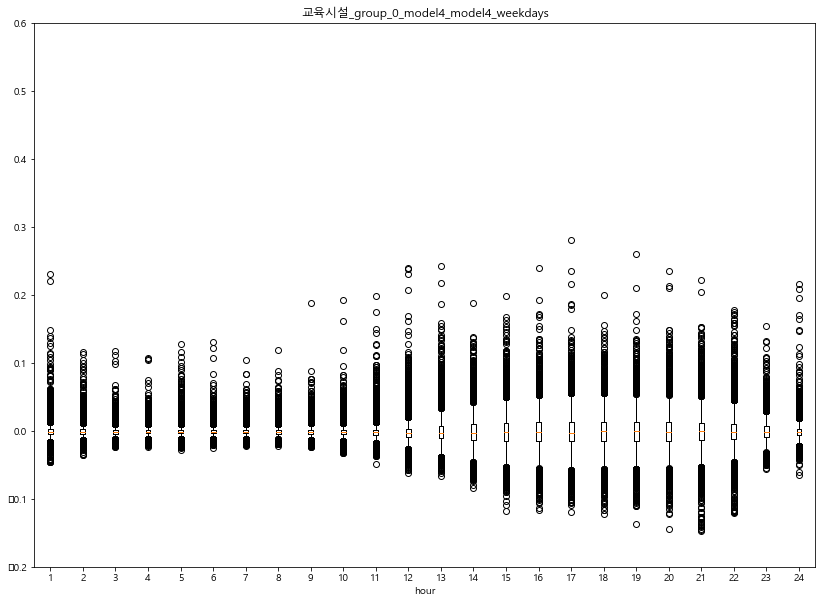

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


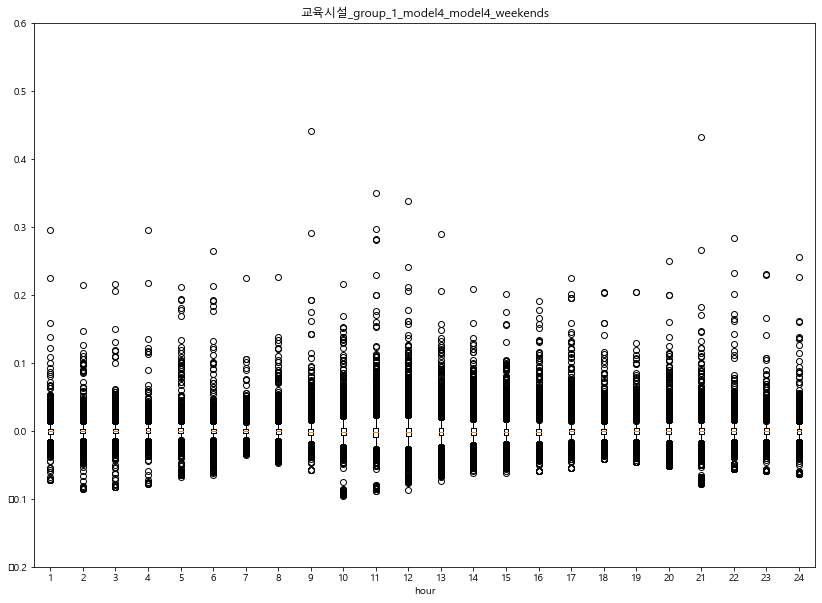

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


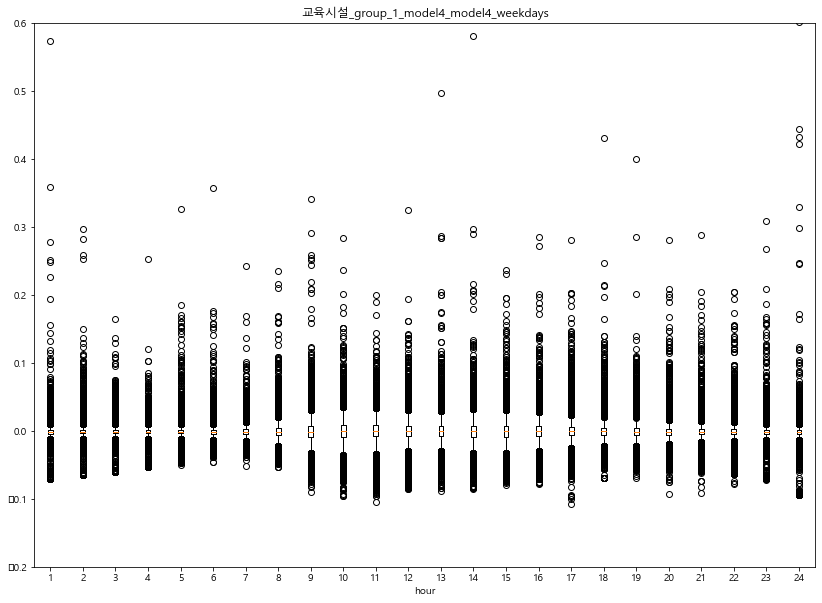

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


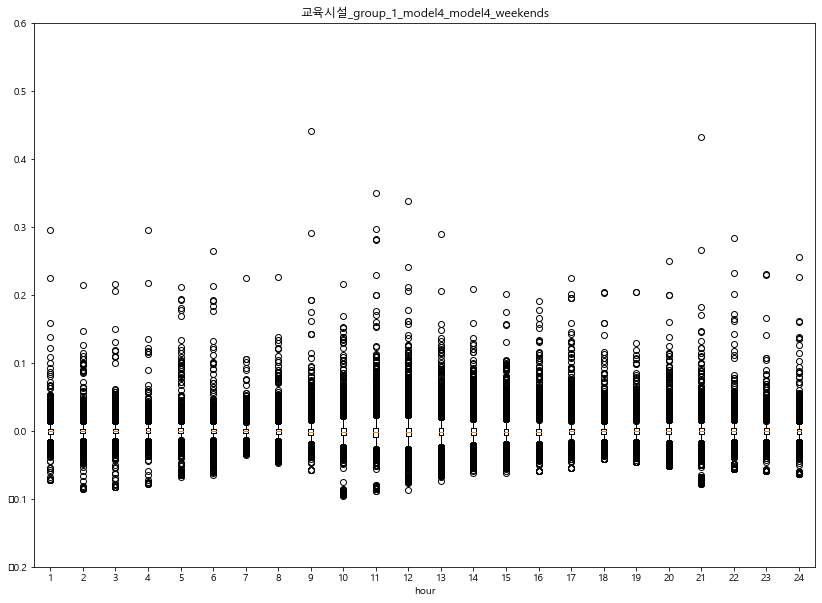

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


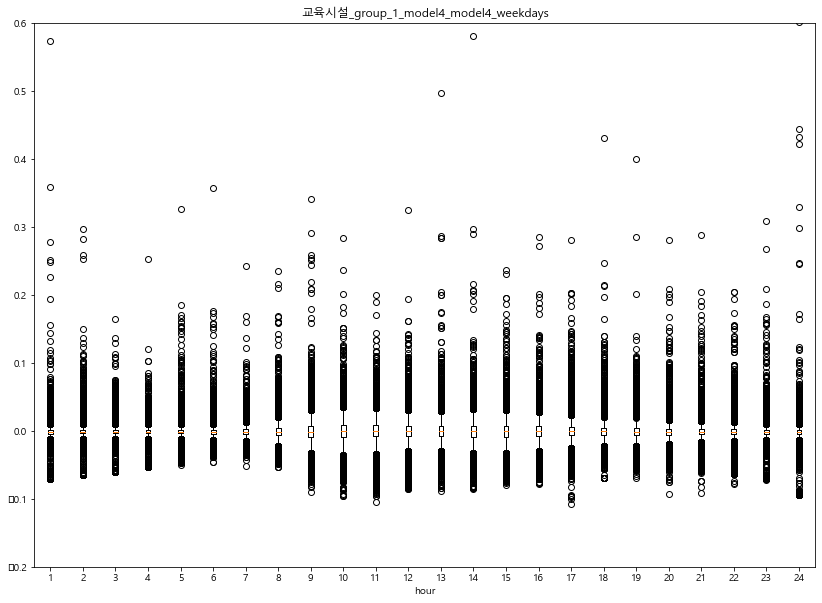

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


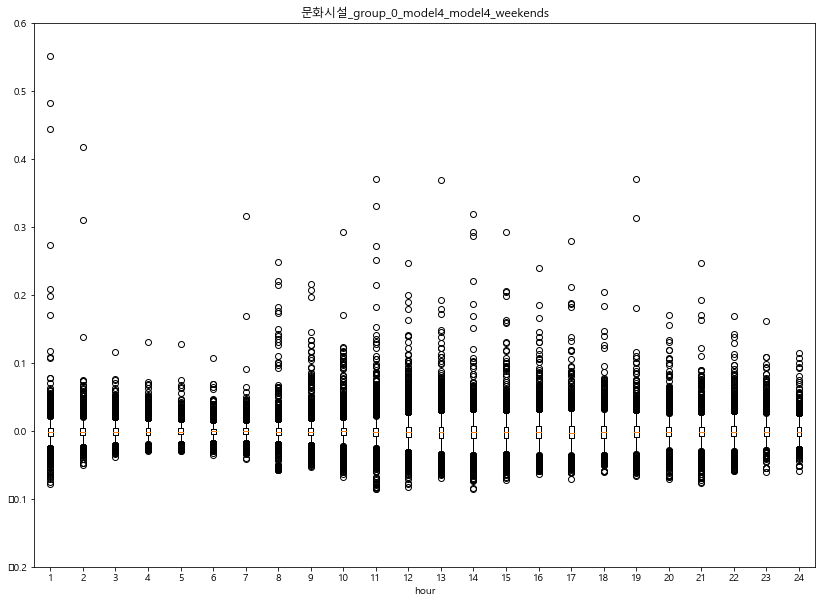

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


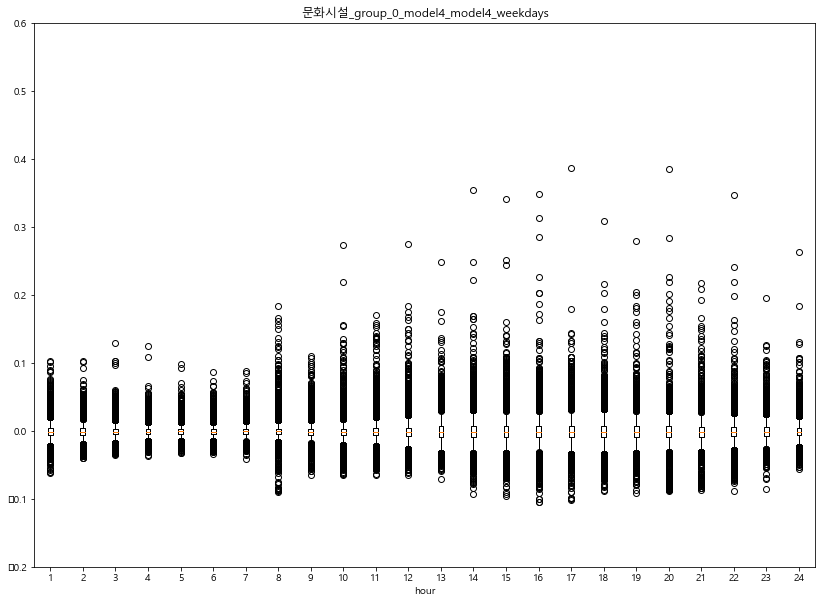

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


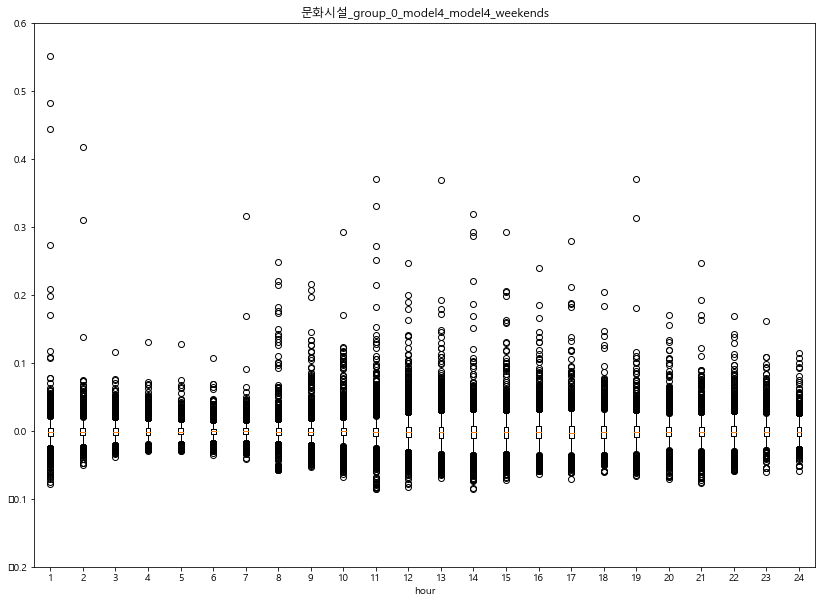

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


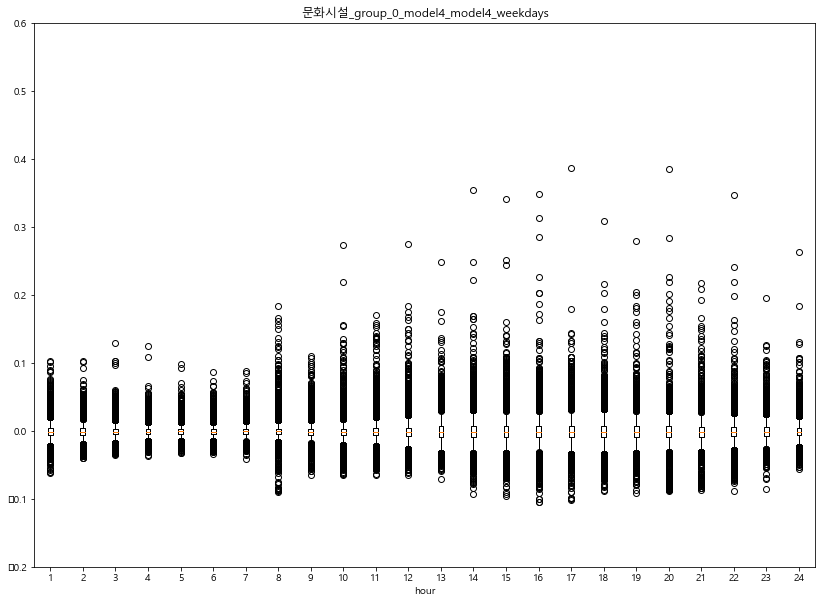

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


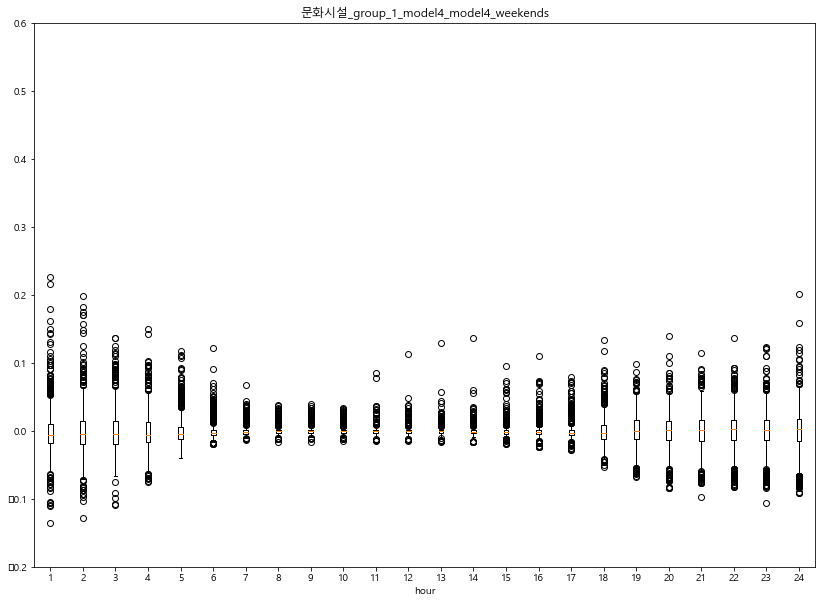

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


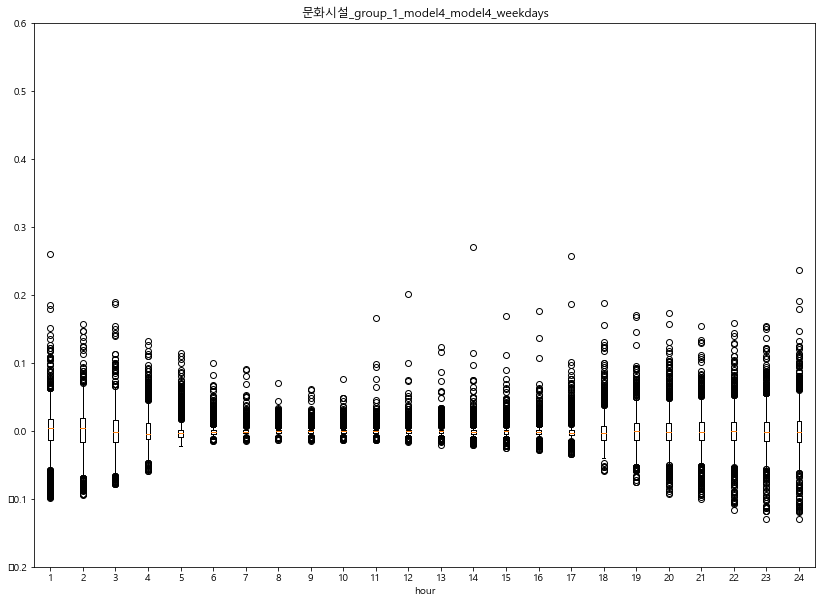

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


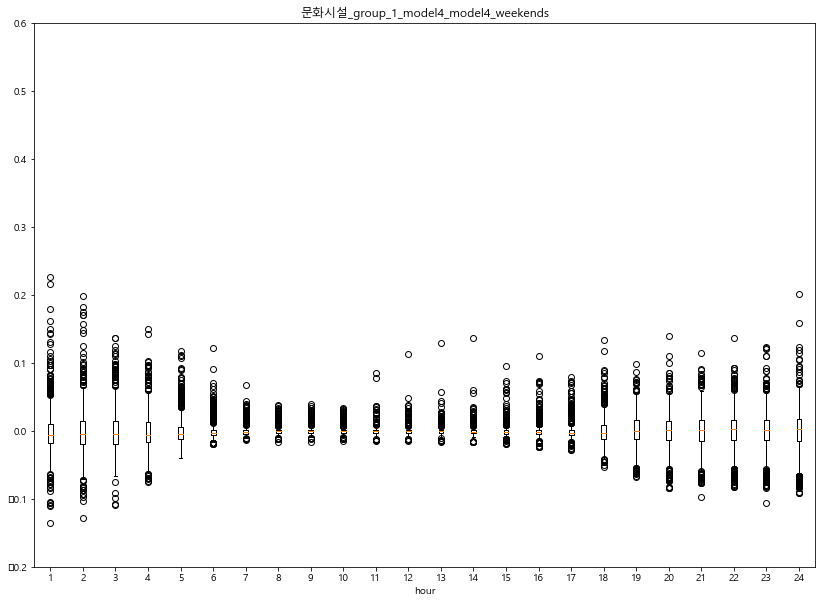

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


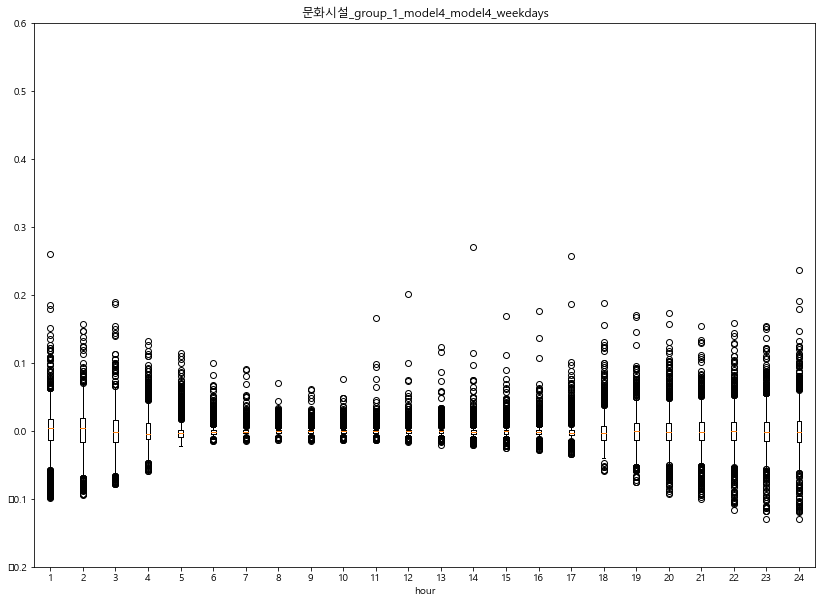

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


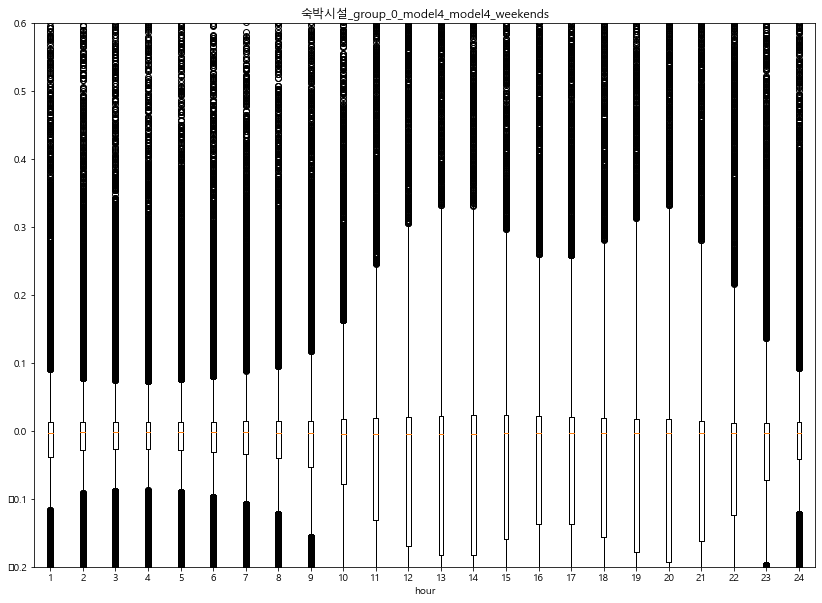

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


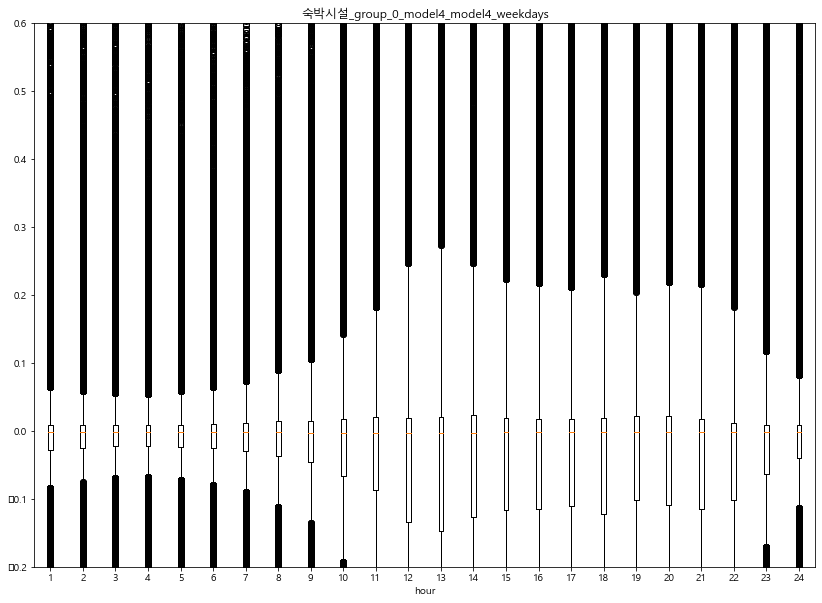

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


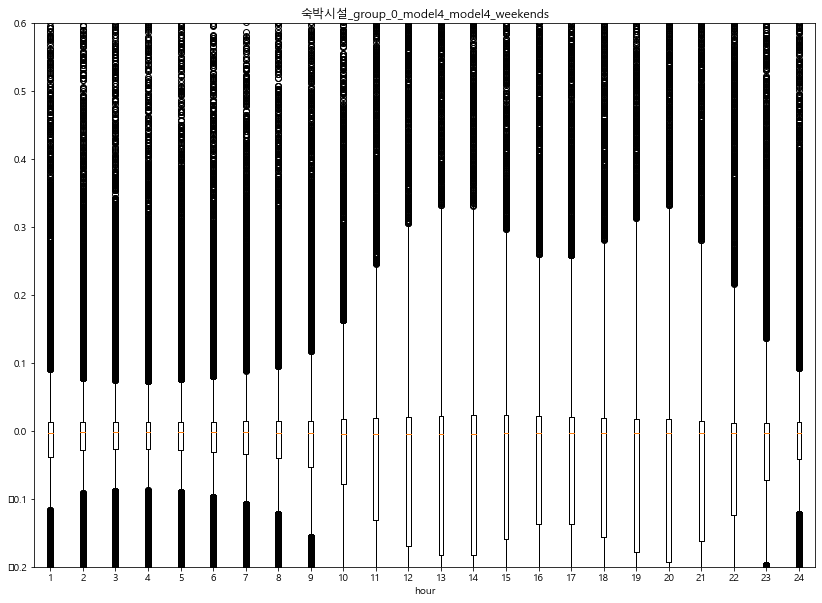

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


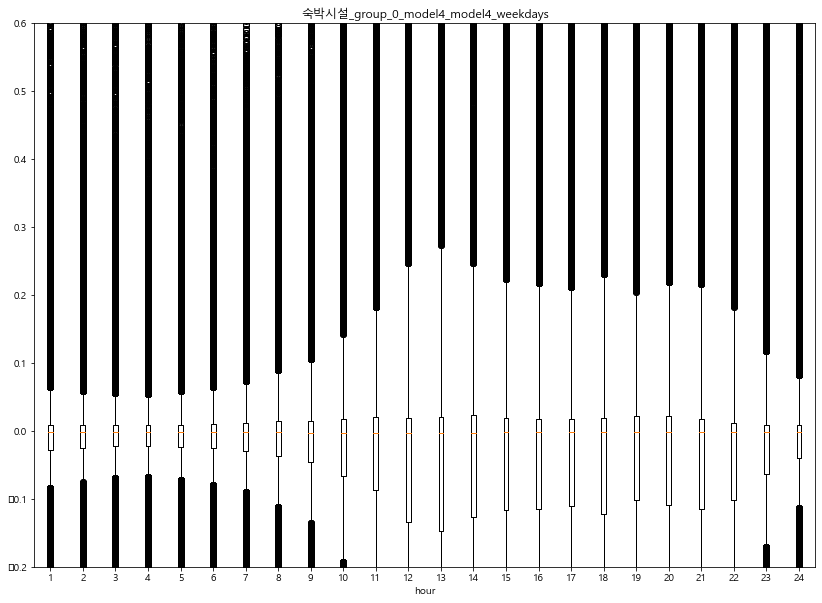

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


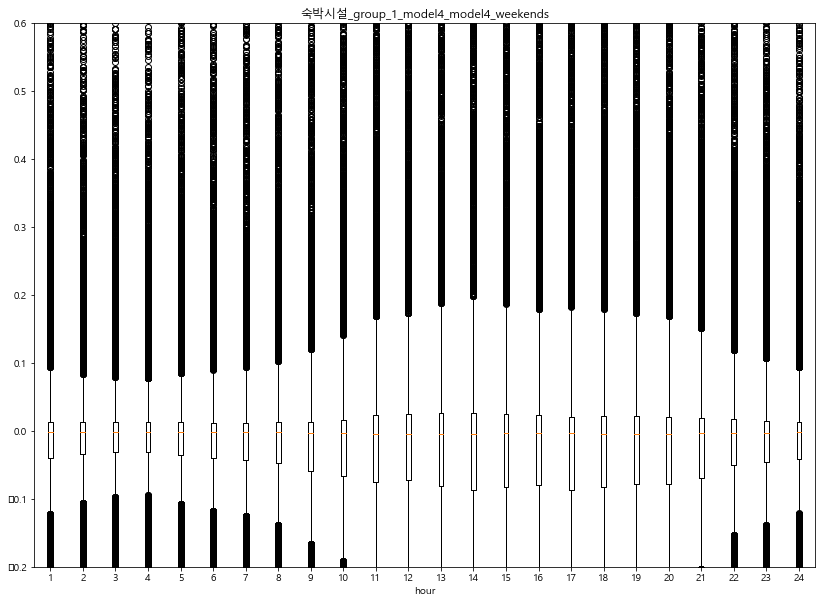

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


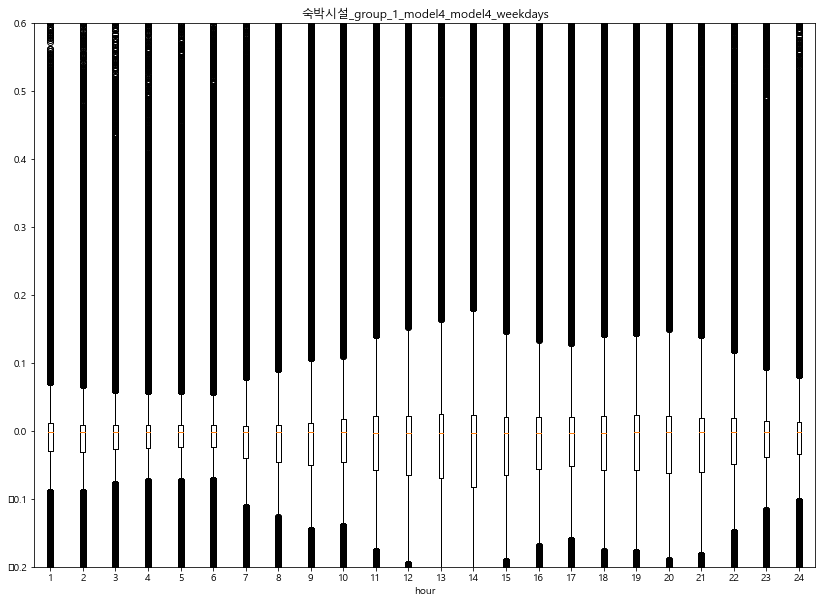

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


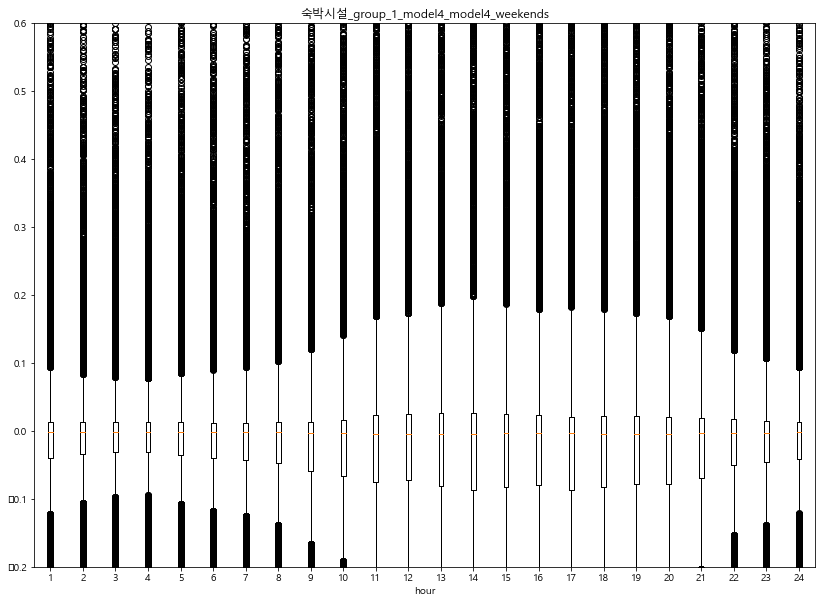

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


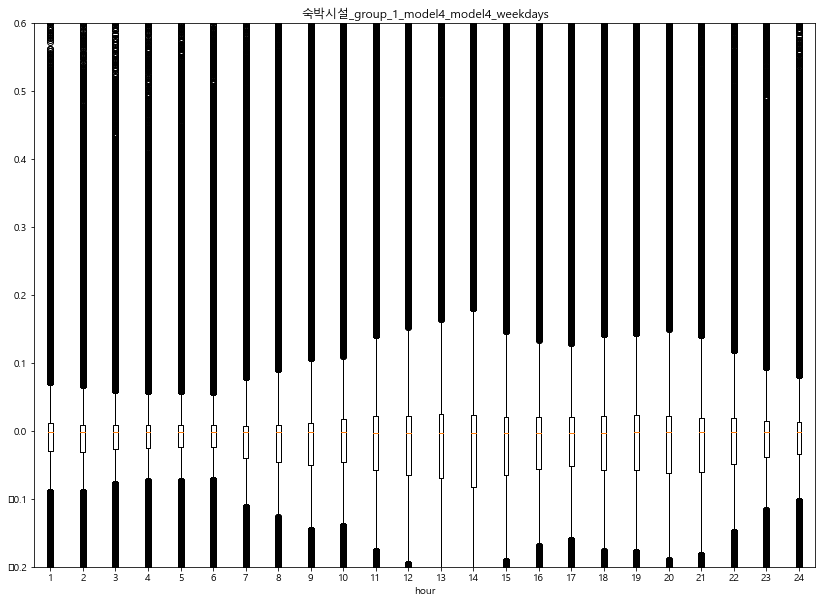

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


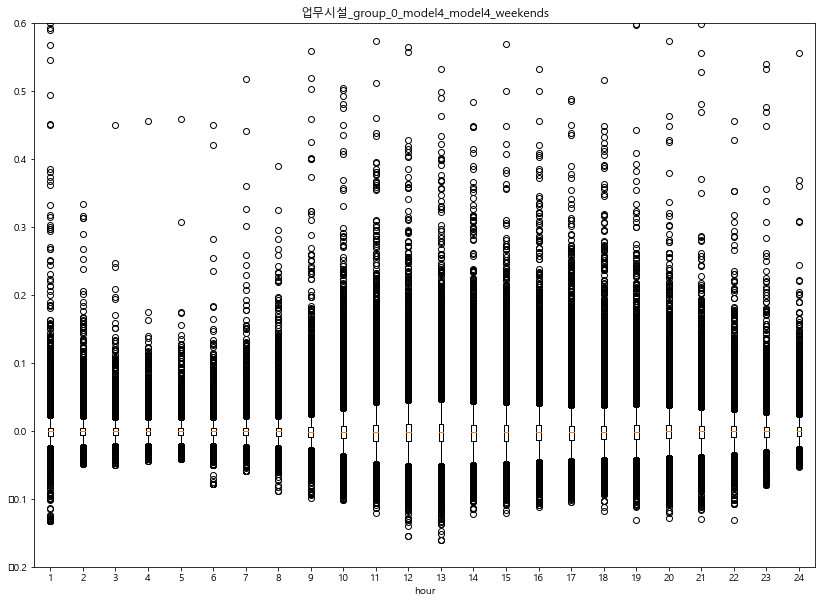

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


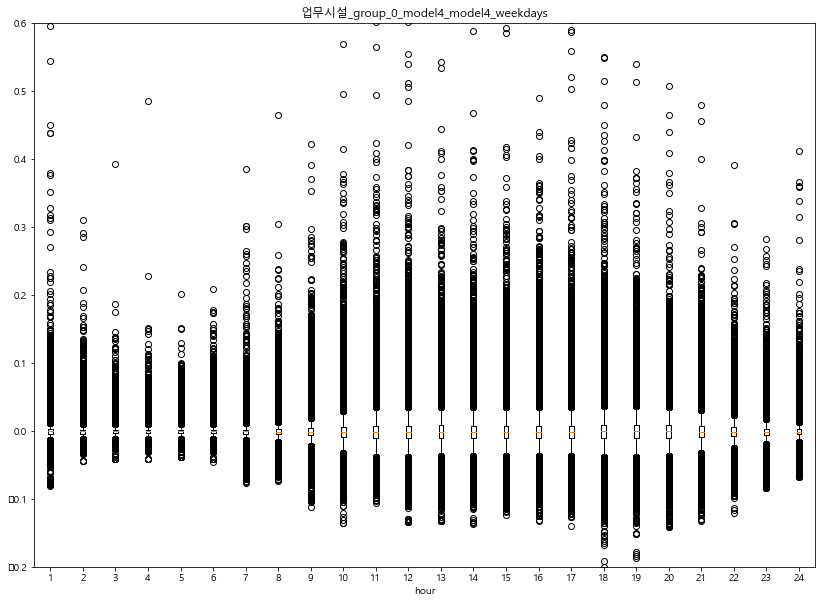

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


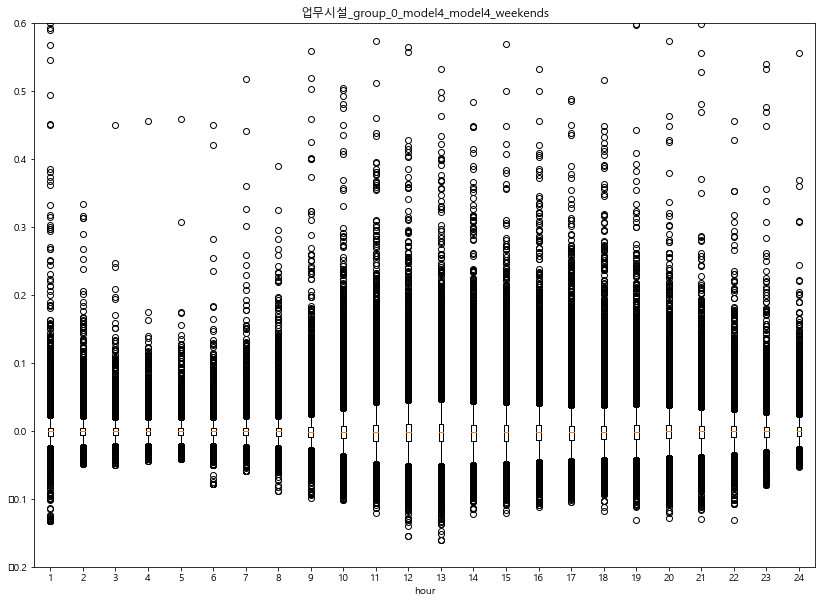

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


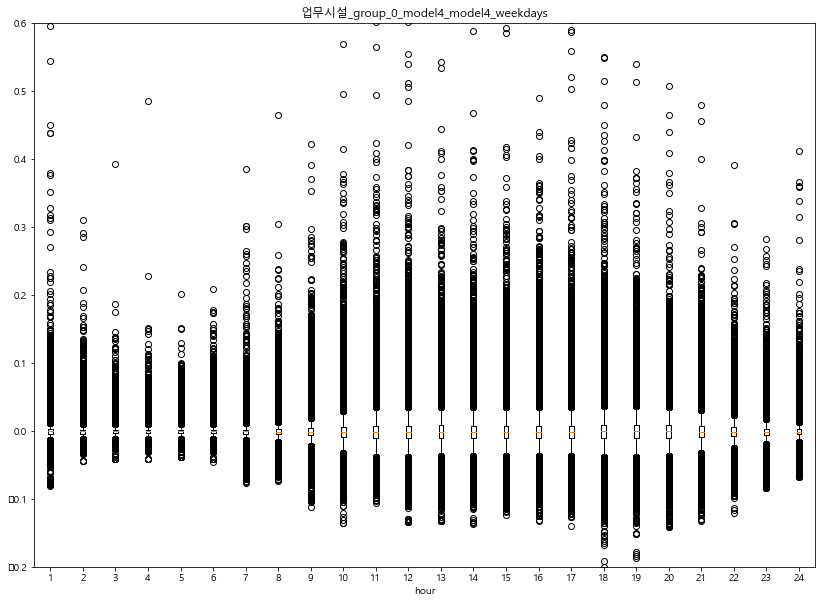

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


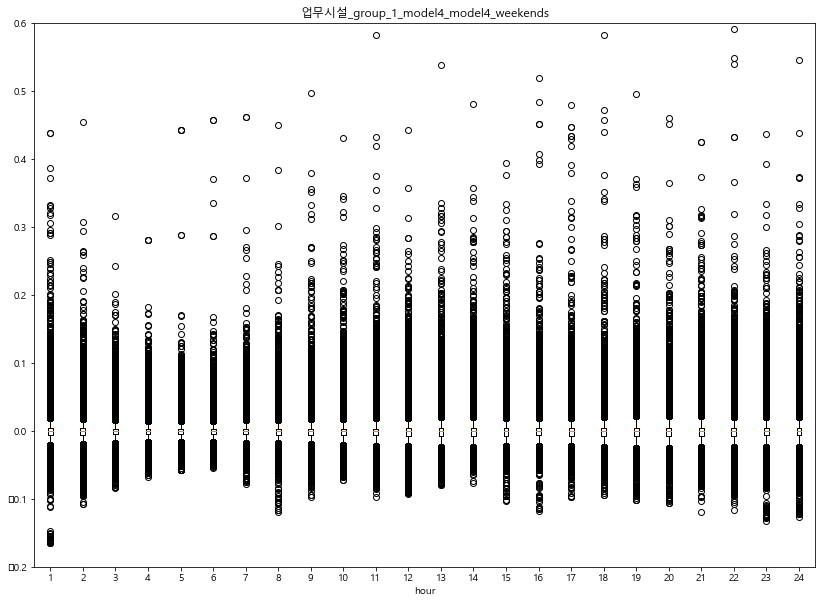

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


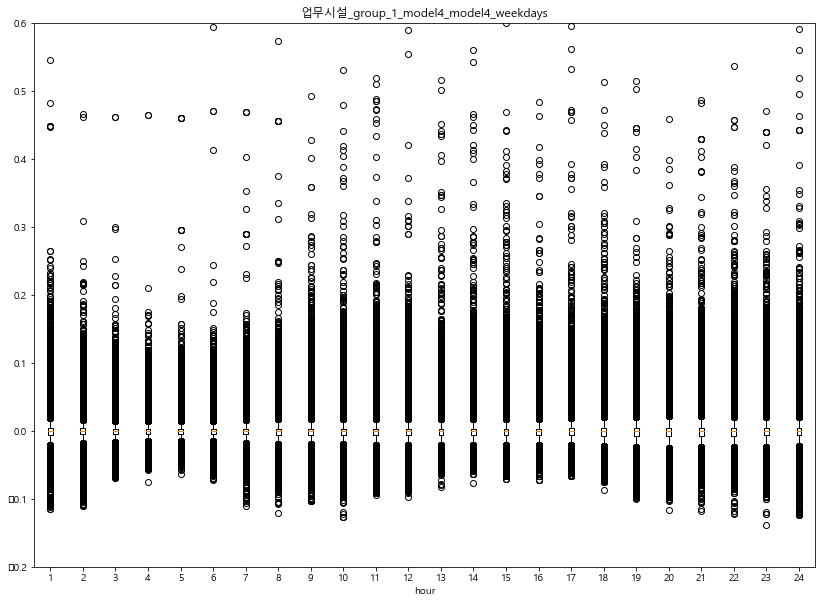

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


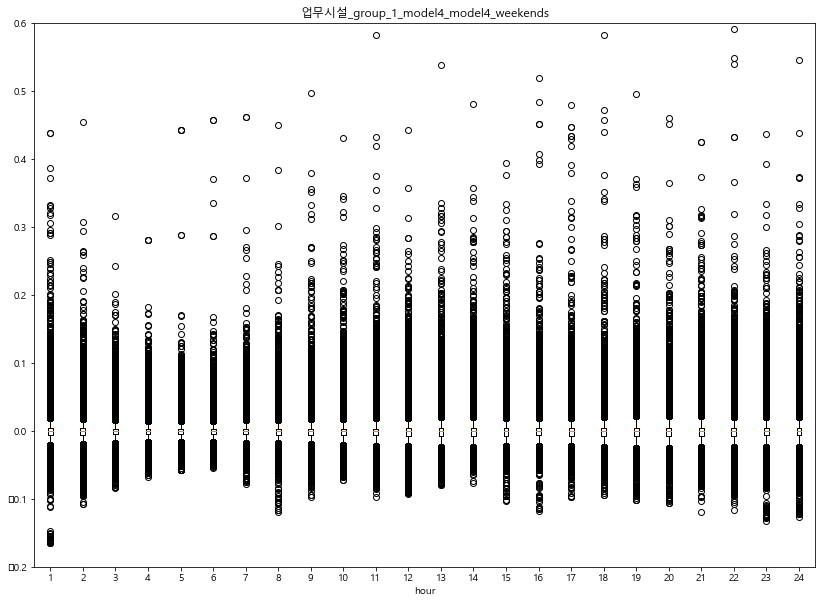

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


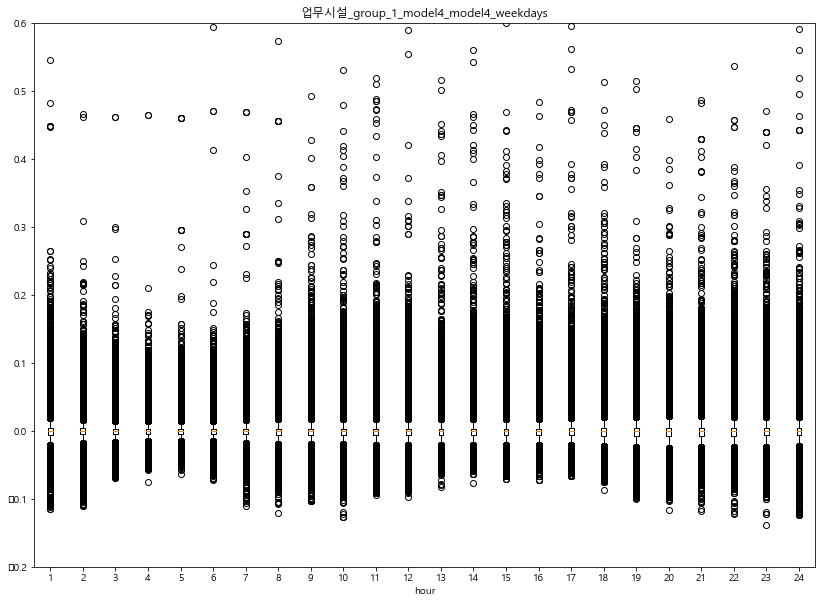

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


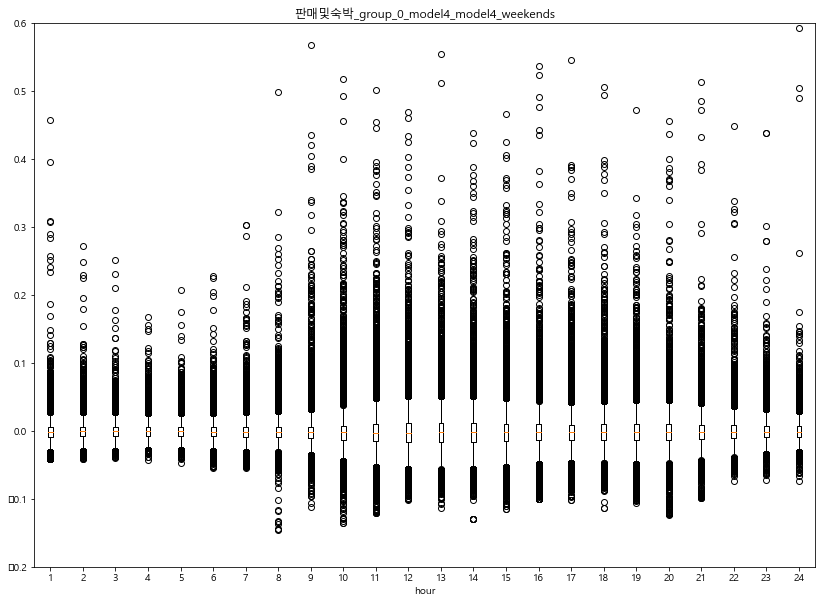

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


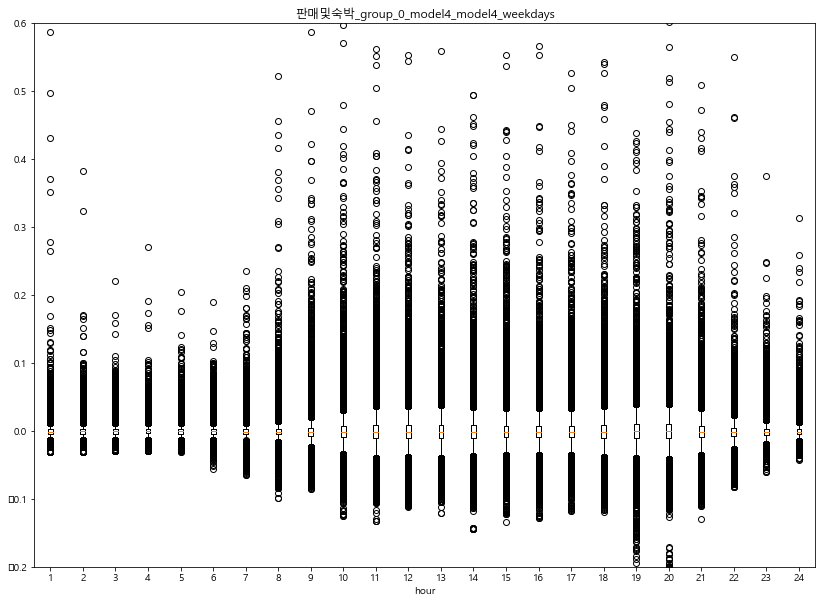

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


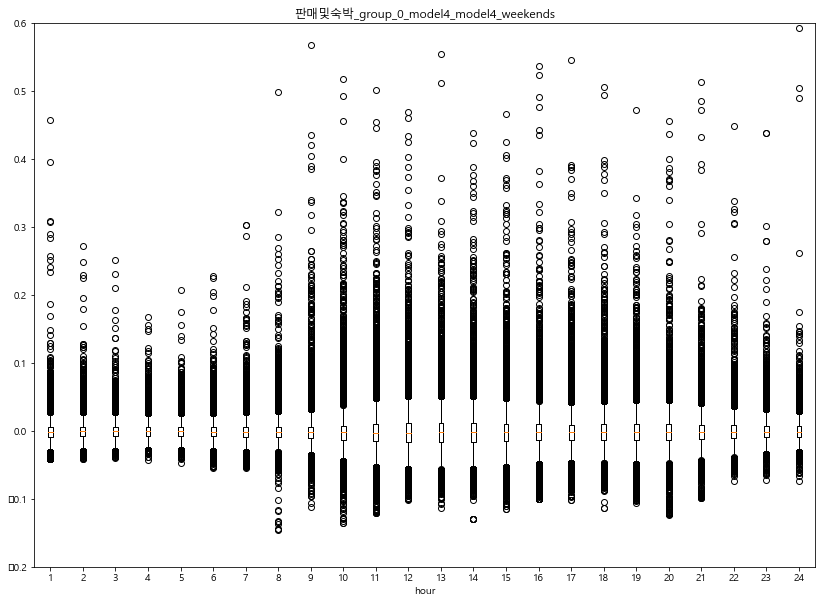

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


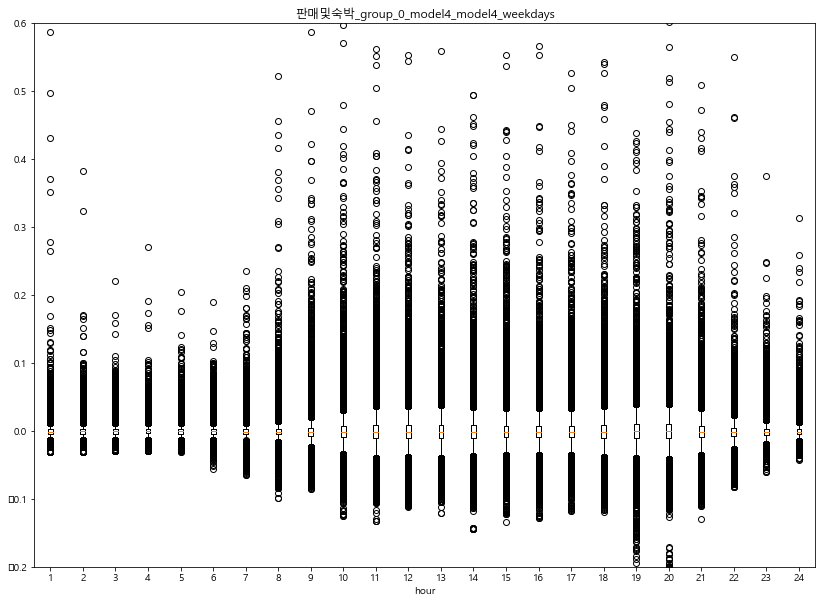

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


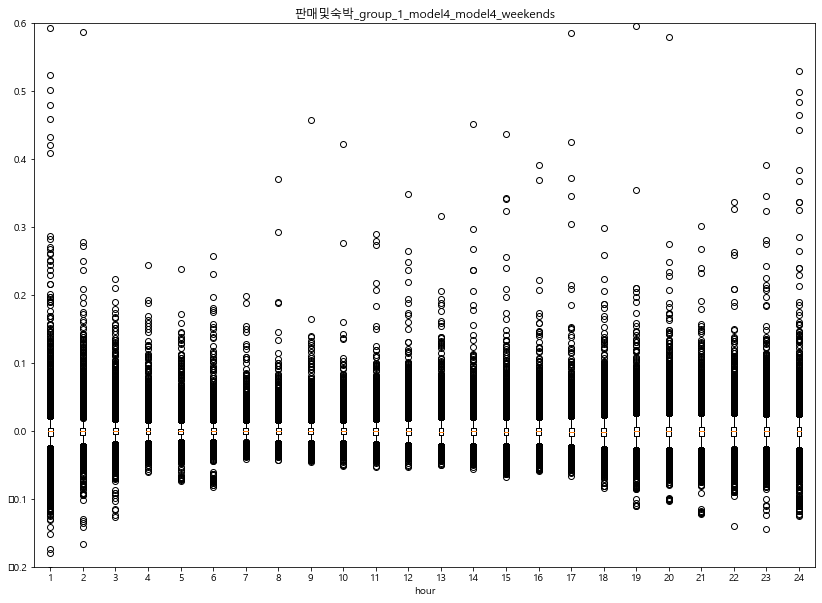

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


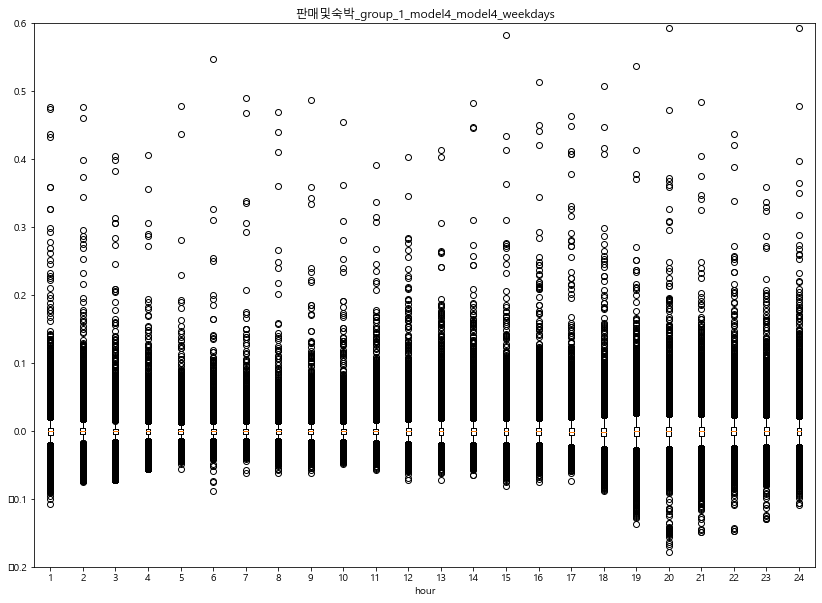

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


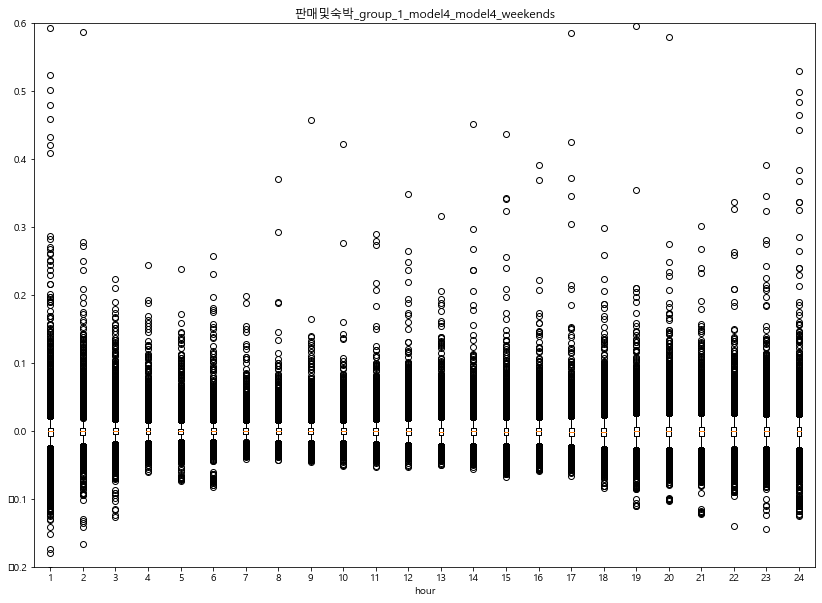

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


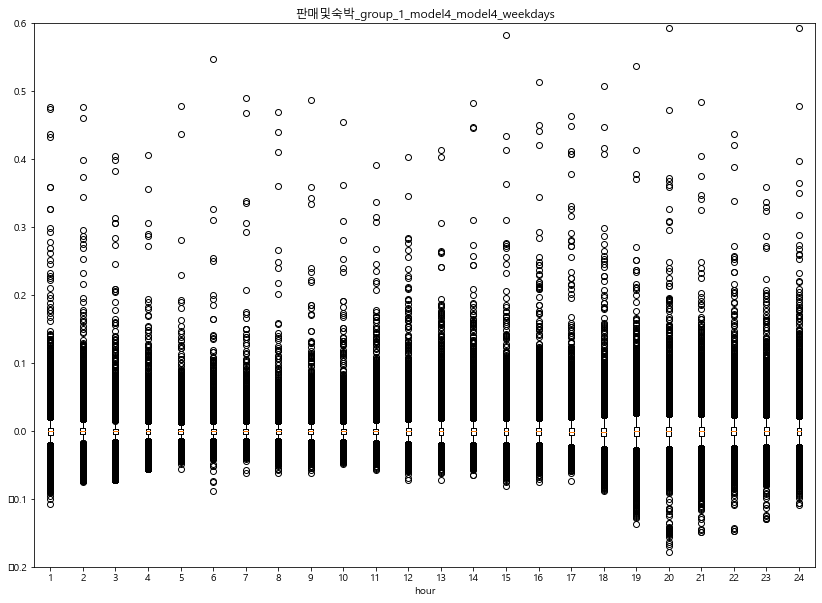

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


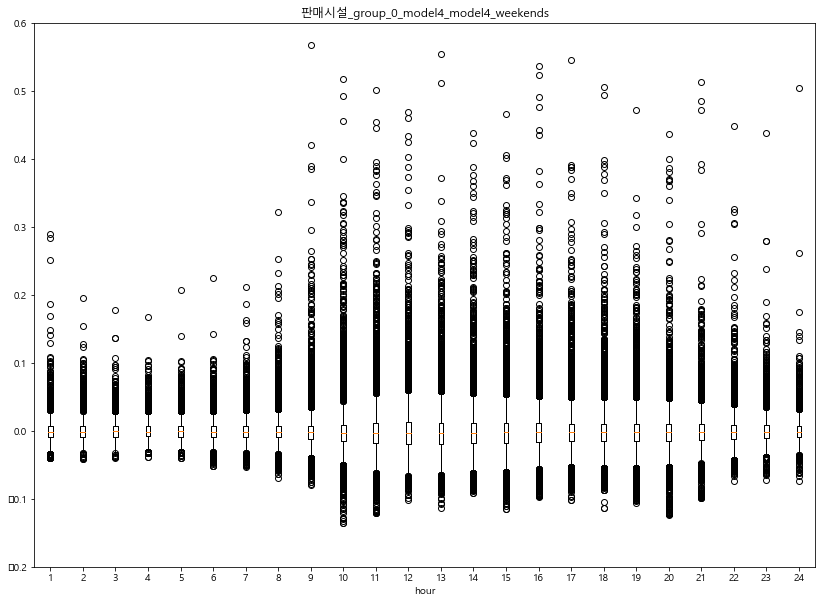

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


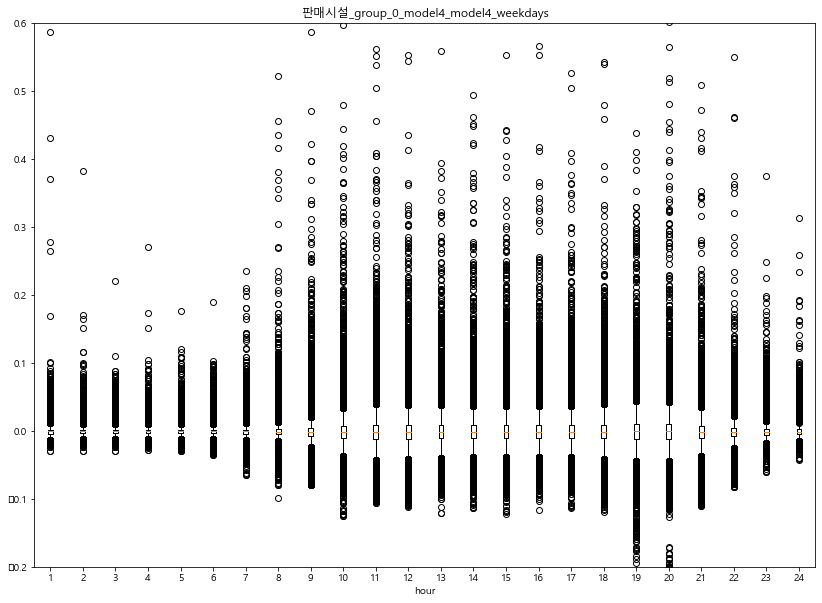

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


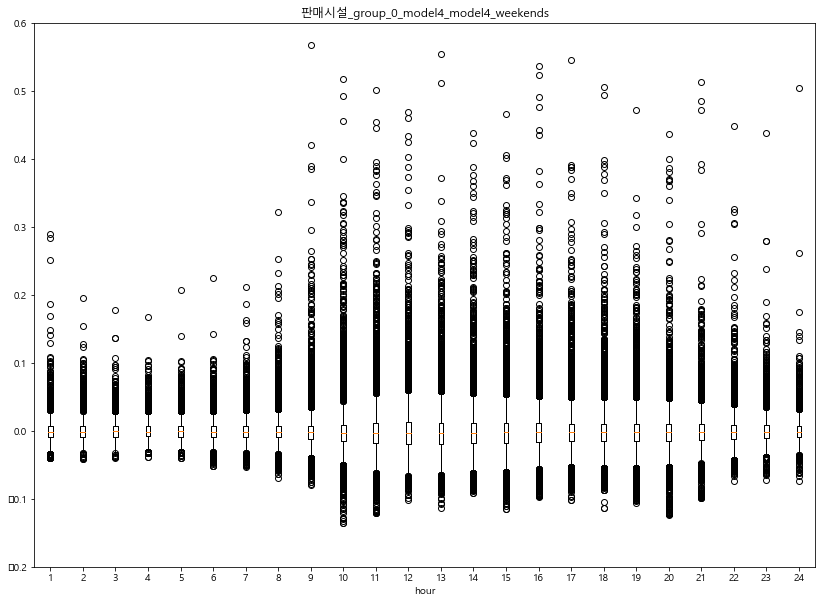

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


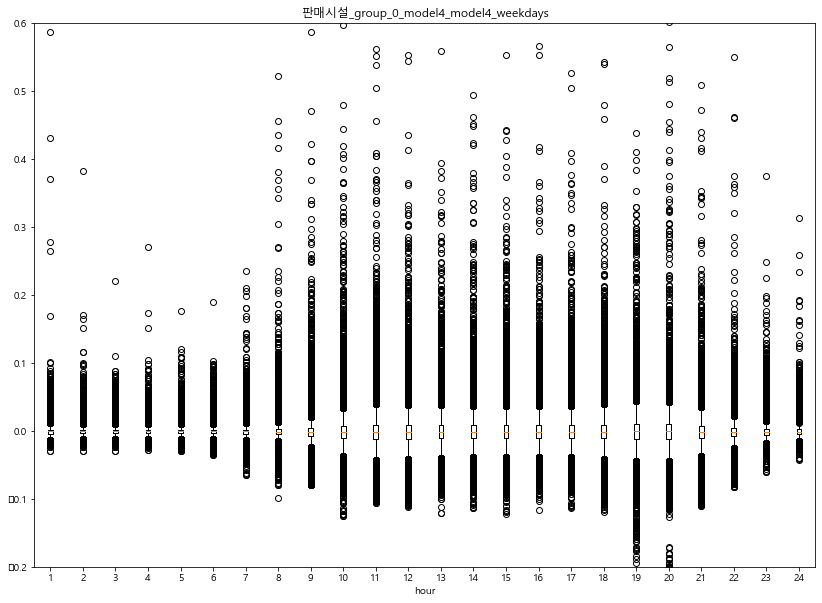

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


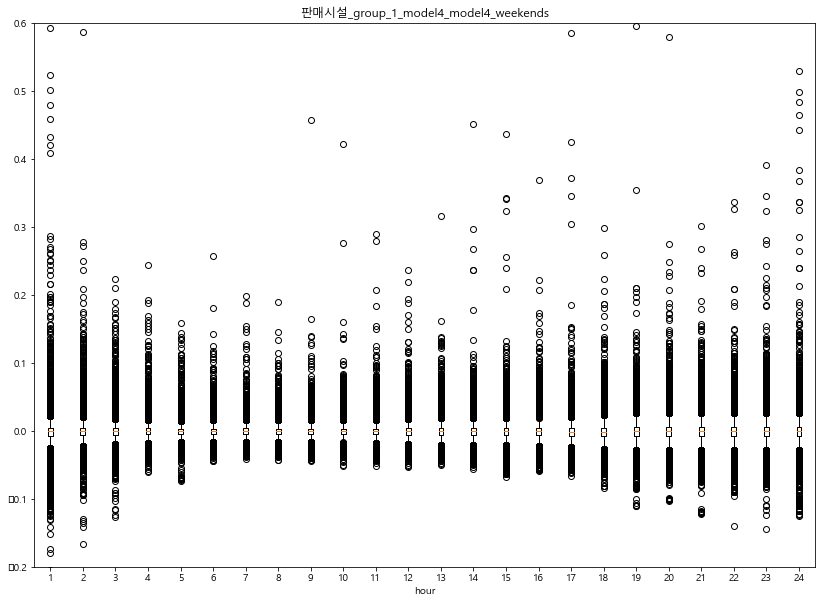

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


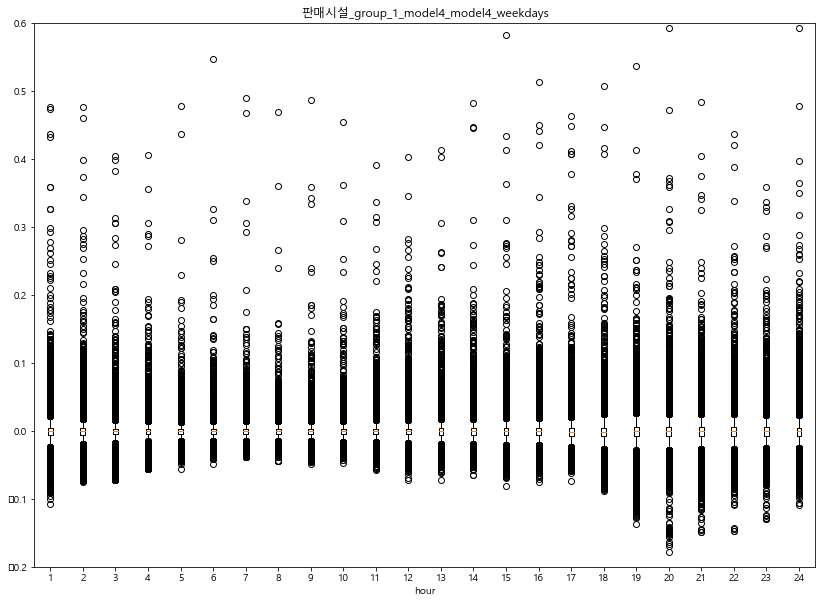

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


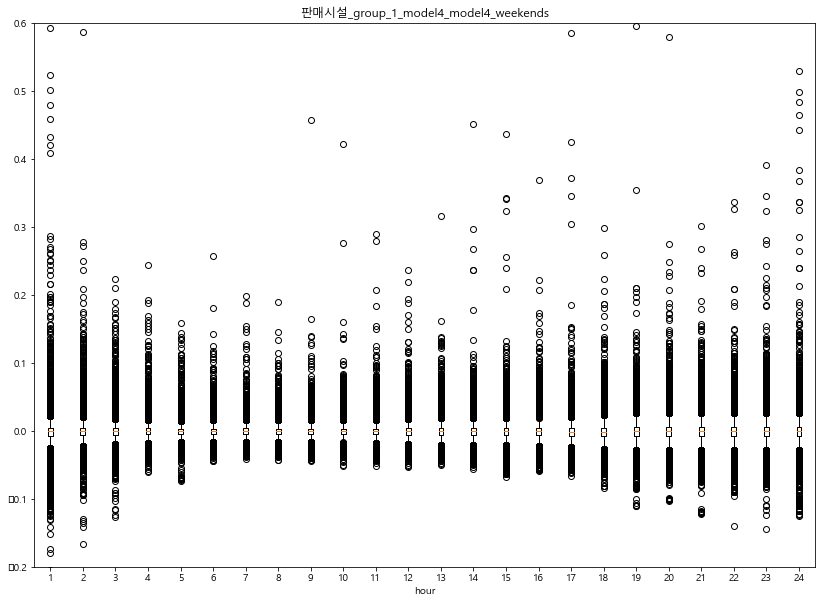

c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\joo09\appdata\local\programs\python\python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


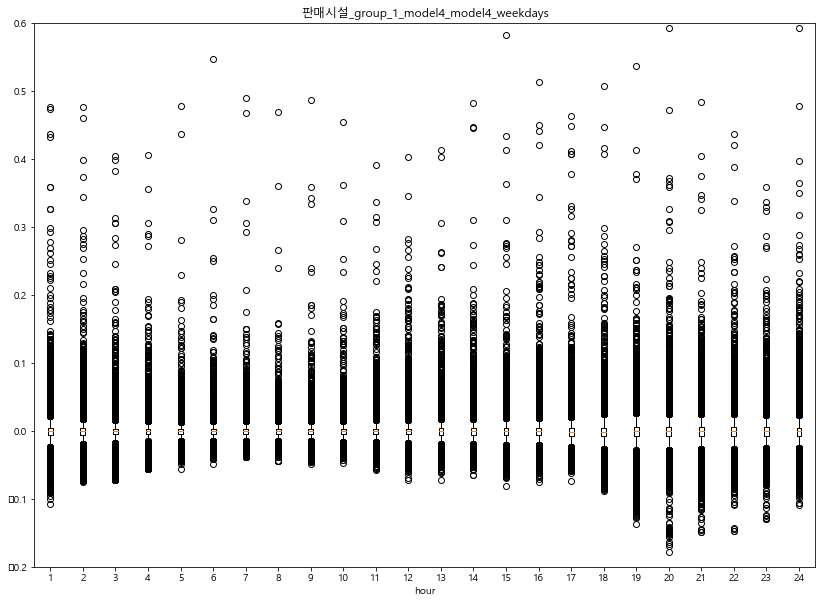

In [32]:
import model_library as lib
import ClusterAnalysis as ca

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
cwdir = os.getcwd()
import sys
sys.path.append(cwdir + '\\module')
import table as tb

import math
import shutil
from sklearn.cluster import KMeans
from sklearn.metrics import *
from distutils.dir_util import copy_tree
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from validclust import dunn
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import k_means
from sklearn import metrics
import matplotlib.cm as cm
import numpy as np
from matplotlib import gridspec
from sklearn.cluster import KMeans
from sklearn.cluster import k_means
from sklearn.metrics import silhouette_samples, silhouette_score

from statsmodels.multivariate.manova import MANOVA

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgunbd.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

def read_excel(excel) :
	df = pd.read_excel(excel)
	if 'Unnamed: 0' in df.columns :
		df.drop('Unnamed: 0', axis = 1, inplace = True)

	if 'Unnamed: 0.1' in df.columns :
		df.drop('Unnamed: 0.1', axis = 1, inplace = True)

	return df
		
def newfolder(directory):
	try:
		if not os.path.exists(directory):
			os.makedirs(directory)
	except OSError:
		print ('Error: Creating directory. ' +  directory)


def newfolderlist(directory, folderlist):
	for i, names in enumerate(folderlist):
		directory_temp = directory + '\\' + names
		try:
			if not os.path.exists(directory_temp):
				os.makedirs(directory_temp)
		except OSError:
			print ('Error: Creating directory. ' +  directory_temp)

def copyfile(src_dir, dst_dir, src_file) :
	src = src_dir + '\\' + src_file
	dst = dst_dir
	shutil.copyfile(src, dst)

def remove(path):
	# """ param <path> could either be relative or absolute. """
	if os.path.isfile(path) or os.path.islink(path):
		os.remove(path)  # remove the file

	elif os.path.isdir(path):
		shutil.rmtree(path)  # remove dir and all contains
		
	else:
		raise ValueError("file {} is not a file or dir.".format(path))


def all_score(X, num_clusters) :
	
	X_num = []
	for i in range(len(X)) :
		X_num.append(str(i + 1))
	
	cluster_df = pd.DataFrame(columns = ['num_clusters', 'labels', 'dist'])
	cluster_num = 0
	
	for num in num_clusters :
		_, cluster_labels, _ = k_means(X, n_clusters = num)
		dist = pairwise_distances(X)
#		 cluster = KMeans(n_clusters = num)
#		 cluster_labels = cluster.fit_predict(X)
		
		cluster_df.loc[cluster_num, 'num_clusters'] = num
		cluster_df.loc[cluster_num, 'labels'] = cluster_labels
		cluster_df.loc[cluster_num, 'dist'] = dist
		cluster_num += 1
	
	cluster_df.reset_index(drop = True, inplace = True)
	
	all_score_df = pd.DataFrame(columns = ['num_clusters', 'silhouette_score', 'dunn index', \
										   'calinski_harabasz_score','davies_bouldin_score'])
	all_score_num = 0
	dist = pairwise_distances(X)
	
	for i in range(len(num_clusters)) :
		all_score_df.loc[all_score_num, 'num_clusters'] = cluster_df.loc[i, 'num_clusters']
		temp_label = cluster_df.loc[i, 'labels']
		temp_dist = cluster_df.loc[i, 'dist']
	
		all_score_df.loc[all_score_num, 'silhouette_score'] = silhouette_score(X, temp_label)
		all_score_df.loc[all_score_num, 'dunn index'] = dunn(temp_dist, temp_label)
		all_score_df.loc[all_score_num, 'calinski_harabasz_score'] = \
												metrics.calinski_harabasz_score(X, temp_label)
		all_score_df.loc[all_score_num, 'davies_bouldin_score'] = \
												davies_bouldin_score(X, temp_label)
		
		all_score_num += 1
		
	all_score_df.reset_index(drop = True, inplace = True)
		
	
	return cluster_df, all_score_df


def all_score_plot(X, all_score_df, plot) :
	
	max_silh = max(all_score_df.loc[:, 'silhouette_score'])
	max_dunn = max(all_score_df.loc[:, 'dunn index'])
	max_chscore = max(all_score_df.loc[:, 'calinski_harabasz_score'])
	max_dbi = max(all_score_df.loc[:, 'davies_bouldin_score'])
	min_dbi = min(all_score_df.loc[:, 'davies_bouldin_score'])
	
	mp_silh = 0
	mp_dunn = 0
	mp_chscore = 0
	mp_dbi = 0
	minp_dbi = 0
	
	for i in range(all_score_df.shape[0]) :
		if all_score_df.loc[i, 'silhouette_score'] == max_silh :
			mp_silh = all_score_df.loc[i, 'num_clusters']
			
		if all_score_df.loc[i, 'dunn index'] == max_dunn :
			mp_dunn = all_score_df.loc[i, 'num_clusters']
			
		if all_score_df.loc[i, 'calinski_harabasz_score'] == max_chscore :
			mp_chscore = all_score_df.loc[i, 'num_clusters']
			
		if all_score_df.loc[i, 'davies_bouldin_score'] == max_dbi :
			mp_dbi = all_score_df.loc[i, 'num_clusters']
		
		if all_score_df.loc[i, 'davies_bouldin_score'] == min_dbi :
			minp_dbi = all_score_df.loc[i, 'num_clusters']
	
	
	for i in range(all_score_df.shape[0]) :
		all_score_df.loc[i, 'silhouette_score'] = all_score_df.loc[i, 'silhouette_score'] / max_silh
		all_score_df.loc[i, 'dunn index'] = all_score_df.loc[i, 'dunn index'] / max_dunn
		all_score_df.loc[i, 'calinski_harabasz_score'] = all_score_df.loc[i, 'calinski_harabasz_score'] / max_chscore
		all_score_df.loc[i, 'davies_bouldin_score'] = all_score_df.loc[i, 'davies_bouldin_score'] / max_dbi
	
	
	if plot == 1 :
		
		# plot Profiles
		plt.rcParams["figure.figsize"] = (12, 5)
		if X.shape[1] == 2 :
			for i in range(X.shape[0]) :
				plt.plot(X[i][0], X[i][1], c = 'r', marker = 'o')
			plt.title('samples')
			plt.show()
			
		else :
			hours_ex = []
			for i in range(1, X.shape[1] + 1) :
				hours_ex.append(i)
			
			for i in range(X.shape[0]) :
				plt.plot(hours_ex, X[i])
			
			plt.xlim(1, X.shape[1])
			plt.xlabel('hours')
			plt.ylabel('KWh')
			plt.title('random profiles')
			plt.show()

		fig = plt.figure()
		ax = fig.add_subplot(1, 1, 1)
		plt.rcParams["figure.figsize"] = (12, 5)
		xvalues = all_score_df.loc[:, 'num_clusters'].astype(int)

		y_silh = all_score_df.loc[:, 'silhouette_score']
		y_dunn = all_score_df.loc[:, 'dunn index']
		y_chscore = all_score_df.loc[:, 'calinski_harabasz_score']
		y_dbi = all_score_df.loc[:, 'davies_bouldin_score']

		plt.plot(xvalues, y_silh, label = 'Silhouette score', c = 'b')
		plt.plot(xvalues, y_dunn, label = "Dunn's index", c = 'orange')
		plt.plot(xvalues, y_chscore, label = 'Calinski Harabasz score', c = 'r')
		plt.plot(xvalues, y_dbi, label = 'Davies Bouldin score', c = 'green')

	#	 plt.axvline(x = mp_silh, c = 'b', alpha = 0.5)
	#	 plt.axvline(x = mp_dunn, c = 'orange', alpha = 0.5)
	#	 plt.axvline(x = mp_chscore, c = 'r', alpha = 0.5)
	#	 plt.axvline(x = mp_dbi, c = 'green', alpha = 0.5)

		plt.xlim(min(all_score_df.loc[:, 'num_clusters']), max(all_score_df.loc[:, 'num_clusters']))
		major_ticks = xvalues.astype(int)
		ax.set_xticks(major_ticks)

		plt.xlabel('number of clusters')
		plt.ylabel('score (normalized)')
		plt.grid(True, axis='x', color='black', alpha = 0.5, linestyle='--')
		plt.legend()
		plt.show()
	
	
	df_optimal = pd.DataFrame(columns = ['silhouette_score', 'dunn index', 'calinski_harabasz_score', 'davies_bouldin_score'])
	df_optimal.loc[0, :] = [mp_silh, mp_dunn, mp_chscore, minp_dbi]
	df_optimal.loc[1, :] = [max_silh, max_dunn, max_chscore, min_dbi]
	df_optimal.index = ['optimal_K', 'score']
	
	
	return df_optimal

def all_score_set(X, num_clusters, plot) :
	cluster_df, all_score_df = all_score(X, num_clusters)
	df_maxval = all_score_plot(X, all_score_df, plot)
	
	return cluster_df, all_score_df, df_maxval
	

def chs_find(profile, plot) :
	if profile.shape[0] < 13 :
		num_clusters = range(2, profile.shape[0] - 1)
	else :
		num_clusters = range(2, 14)

	X = np.array(profile.loc[:, '1' : '48'].copy())
	
	
	clsuter_df, all_score_df, df_optimal = all_score_set(X, num_clusters, plot)
	K = df_optimal.loc['optimal_K', 'calinski_harabasz_score']
	return K
   

def chs_find(profile, plot) :
	if profile.shape[0] < 13 :
		num_clusters = range(2, profile.shape[0] - 1)
	else :
		num_clusters = range(2, 14)

	X = np.array(profile.loc[:, '1' : '48'].copy())
	
	
	clsuter_df, all_score_df, df_optimal = all_score_set(X, num_clusters, plot)
	K = df_optimal.loc['optimal_K', 'calinski_harabasz_score']
	return K


def chs_find_big(profile, plot) :

	num_clusters = range(2, profile.shape[0])

	X = np.array(profile.loc[:, '1' : '48'].copy())
	
	
	clsuter_df, all_score_df, df_optimal = all_score_set(X, num_clusters, plot)
	K = df_optimal.loc['optimal_K', 'calinski_harabasz_score']
	return K
	
def wanted_centers_plot(info, wanted) :
	for i in range(info.shape[0]) :
		if info.loc[i, 'label'] in wanted :
			plt.plot(range(1, 49), info.loc[i, '1' : '48'])
	plt.show() 

def big_centers_plot(centers) :
	for i in range(centers.shape[0]) :
		if centers.loc[i, 'count'] > 5 :
			alpha_temp = 1
		else :
			alpha_temp = 0
		plt.plot(centers.loc[i, 'center'], label = 'i', alpha = alpha_temp)
	
	plt.show()

def centers_plot(centers) :

	if min(centers.loc[:, 'count'].tolist()) > 5 :
		alpha_rth = 0
	else :
		alpha_rth = 1
	
	if alpha_rth == 0 :
		for i in range(centers.shape[0]) :
			plt.plot(centers.loc[i, 'center'], label = 'i', alpha = 1)

	else :
		for i in range(centers.shape[0]) :
			if centers.loc[i, 'count'] > 5 :
				alpha_temp = 0.3
			else :
				alpha_temp = 1
			plt.plot(centers.loc[i, 'center'], label = 'i', alpha = alpha_temp)
	
	plt.show()
		
########################################################################
# model3, model3cluster, model4 에 '판매및숙박' 폴더 생성되는지 확
class model() :
	def __init__(self, main_dir) :
		pre_dir = main_dir + '\\전체 업태'
		model_dir = main_dir + '\\model'
		try :
			if not os.path.exists(model_dir) :
				os.makedirs(model_dir)
		except OSError :
			print('{} already made'.format(model_dir))
			
		folder_list = []
		for folder in os.listdir(pre_dir) :
			if os.path.isdir(pre_dir + '\\' + folder) :
				folder_list.append(folder)
		print(folder_list)
		
		for num, folder in enumerate(folder_list) :
			temp_dir = model_dir + '\\' + folder
			try :
				if not os.path.exists(temp_dir) :
					os.makedirs(temp_dir)
			except OSError :
				print('{} subfolders already made'.format(temp_dir))
				
		model_list = ['preprocessed', 'model1', 'model2', 'model3', \
						'model3_cluster', 'model4', 'plot']
						
		dayends = ['주중', '주말']
		
		for folder in os.listdir(model_dir) :
			for model_name in model_list :
				if 'model4' not in model_name :
					if 'plot' not in model_name :
						for de in dayends :
							adddir = model_dir + '\\' + folder + '\\' + model_name + '\\' + de
							newfolder(adddir)
		
		for folder in os.listdir(pre_dir) :
			tempdir = pre_dir + '\\' + folder
			weekend_src = tempdir + '\\7_봄가을\\주말'
			weekday_src = tempdir + '\\7_봄가을\\주중'
			
			weekend_dst = model_dir + '\\' + folder + '\\preprocessed\\주말'
			weekday_dst = model_dir + '\\' + folder + '\\preprocessed\\주중'
			
			for f in os.listdir(weekend_src) :
				shutil.copyfile(weekend_src + '\\' + f, weekend_dst + '\\' + f)
			for f in os.listdir(weekday_src) :
				shutil.copyfile(weekday_src + '\\' + f, weekday_dst + '\\' + f)
			
		print('files all pasted...')
		print('ready!')
		
		hours = []
		hours_str = []
		for i in range(1, 25) :
			hours.append(i)
			hours_str.append(str(i))
		hours_ex = []
		hours_ex_str = []
		for i in range(1, 49) :
			hours_ex.append(i)
			hours_ex_str.append(str(i))
			
		condition_list = []
		for folder in os.listdir(model_dir) :
			if os.path.isdir(model_dir + '\\' + folder) :
				condition_list.append(folder)
				
		self.condition_list = condition_list
		self.hours = hours
		self.hours_str = hours_str
		self.hours_ex = hours_ex
		self.hours_ex_str = hours_ex_str
		
		
		self.main_dir = main_dir
		self.src_dir = pre_dir
		self.model_dir = model_dir
		
		
	def reset(self) :
		for everything in os.listdir(self.model_dir) :
			remove(self.model_dir + '\\' + everything)
		self.__init___(self.main_dir)
		
	def model3_unit(self, finaldir, model3dir) :
		# finaldir 은 '봄가을' 전처리 완료 폴더
		# finaldir 속의 ['주중', '주말'] 폴더 속 엑셀파일을 불러와
		# model3dir 의 ['주중', '주말'] 폴더에 model3을 저장하고
		# model3dir 에 profile_48.xlsx 저장함
		
		hours_extend = self.hours_ex
		folderlist = ['주중', '주말']
		folderdays = '주중'
		folderends = '주말'
		
		osdays = finaldir + '\\주중'
		osends = finaldir + '\\주말'
		
		for de in folderlist :
			osnow = finaldir + '\\' + de
			if de == folderdays :
				osnow = osdays
			else :
				osnow = osends
				
			for excel in os.listdir(osnow) :
				os.chdir(osnow)
				temp = read_excel(excel)
				temp_m2 = pd.DataFrame(columns = temp.columns)
				temp.reset_index(drop = True, inplace = True)
				
				check = 0
				for index in range(temp.shape[0]) :
					total_index = temp.loc[index, :].sum()
					if total_index != 0 :
						for cat in temp.columns :
							temp_m2.loc[index, cat] = temp.loc[index, cat] / total_index
							
				os.chdir(model3dir + '\\' + de)
				temp_m2.to_excel(excel)
				print('{} saved'.format(excel), end = '\r')
					
		df = pd.DataFrame(columns = ['excel'] + hours_extend)
		df.columns = df.columns.astype(str)
		df_num = 0

		for folder in os.listdir(model3dir) :
			tempdir = model3dir + '\\' + folder
			if '주중' in folder :
				folderdays = folder
				model3days = tempdir
			elif '주말' in folder :
				folderends = folder
				model3ends = tempdir

		for excel in os.listdir(model3days) :
			print('working on {}'.format(excel), end = '\r')
			os.chdir(model3days)
			temp = lib.read_excel(excel)
			for excel2 in os.listdir(model3ends) :
				os.chdir(model3ends)
				if excel[ : -11] == excel2[ : -11] :
					excel_match = excel2
					temp2 = lib.read_excel(excel_match)
				
			temp.columns = temp.columns.astype(str)
			temp2.columns = temp2.columns.astype(str)
			temp.reset_index(drop = True, inplace = True)
			temp2.reset_index(drop = True, inplace = True)

			df.loc[df_num, 'excel'] = excel[: -11]

			temp_ave = pd.DataFrame(columns = temp.columns)
			temp_ave2 = pd.DataFrame(columns = temp2.columns)

			ave_num = 0

			for cat in temp_ave.columns :
				temp_ave.loc[ave_num, cat] = temp.loc[ : , cat].mean()

			for cat in temp_ave2.columns :
				temp_ave2.loc[ave_num, cat] = temp2.loc[ : , cat].mean() 



			df.loc[df_num, '1' : '48'] = temp_ave.loc[ave_num, '1' : '24'].tolist() \
										+ temp_ave2.loc[ave_num, '1' : '24'].tolist()
			df_num += 1
			
			print('~{}, ~{} is matched'.format(excel[-15 : -5], excel_match[-15 : -5]), end = '\r')

			

		os.chdir(model3dir)
		df.to_excel('profile_48.xlsx')
		self.profile_48  = df
		print('48 hours profile made, shape : {}'.format(df.shape))
		print(self.profile_48)

	def model3(self) :
		
		# finaldir -> self.model_dir + '\\' + 업태 + '\\preprocessed\\주중'  
		# model3 정규화 프로필, 평균 프로필
		# model3 완
		
		## orgdir = '\\업태별'
		## maindir = '\\업태별\\0_전체 업태로 모델 만들기2'
		## finaldir = maindir + '\\전체업태전처리'
		## model2dir / model3dir / model3cluster / model4dir / plotdir성
		
		hours = self.hours
		hours_str = self.hours_str
		hours_extend = self.hours_ex
		hours_ex_str = self.hours_ex_str
		
		for condition in self.condition_list :
			srcdir = self.src_dir + '\\' + condition
			cwdir = self.model_dir + '\\' + condition 
			finaldir = cwdir + '\\preprocessed'
			model3dir = cwdir + '\\model3'
			model3cluster = cwdir + '\\model3_cluster'
			model4dir = cwdir + '\\model4'
			
			self.model3_unit(finaldir, model3dir)

	def model3_cluster_unit(self, finaldir, model3dir, model3cluster, condition) :
		os.chdir(model3dir)
		profile = read_excel('profile_48.xlsx')
		print('{} clustering...'.format(condition))
		K = ca.chs_find(profile, 0)
		locals()['info_{}'.format(condition)], locals()['centers_{}'.format(condition)] = \
		ca.cluster_new(profile, K)
		print('optimal K = {}, based on "calinski-harabasz score"'.format(K))
		K = int(K)
		_, cluster_labels, _ = k_means(profile.loc[:, '1' : '48'], n_clusters = K)

		for i in range(locals()['centers_{}'.format(condition)].shape[0]) :
			print('{}th group profile'.format(i))
			ca.wanted_centers_plot(locals()['info_{}'.format(condition)], [i])
			
		for group_num in range(K) :
			locals()['group_{}'.format(group_num)] = []
			
			for i in range(len(cluster_labels)) :
				if cluster_labels[i] == group_num :
					locals()['group_{}'.format(group_num)].append(i)
		
		file_list = []
		for group_num in range(K) :
			file_list.append('group_{}'.format(group_num))
		
		for group_num in range(K) :
			locals()['group_{}'.format(group_num)] = \
			profile.loc[locals()['group_{}'.format(group_num)], :]
			
			locals()['group_{}'.format(group_num)].reset_index(drop = True, inplace = True)
		
			os.chdir(model3cluster)
			locals()['group_{}'.format(group_num)].to_excel('profile_48_group_{}.xlsx'.format(group_num))
		
			group_info = locals()['group_{}'.format(group_num)].loc[:, 'excel'].tolist()
			print('{}th group = {}, size = {}'.format(group_num, group_info[ : 5], len(group_info)))
			
			# 새로운 폴더 만들기
			newfolderlist(model3cluster, file_list)
			for f in file_list :
				newfolderlist(model3cluster + '\\' + f, ['주중', '주말'])
			
			# finaldir에서 옮기
			for excel_name in group_info :
				for folder in os.listdir(finaldir) : # folder = ['주중', '주말']
					tempdir = finaldir + '\\' + folder
					for real_excel in os.listdir(tempdir) : # ex - '주중' 폴더에
						if excel_name in real_excel :
							src = tempdir
							dst = model3cluster + '\\group_{}\\'.format(group_num) + folder
							#shutil.copyfile(src + '\\' + real_excel, dst + '\\' + real_excel)
							
			# model3 에서 옮기기
			for excel_name in group_info :
				for folder in os.listdir(model3dir) : # folder = ['주중', '주말']
					tempdir = model3dir + '\\' + folder
					if os.path.isdir(tempdir) :
						for real_excel in os.listdir(tempdir) : # ex - '주중' 폴더에
							if excel_name in real_excel :
								src = tempdir
								newfolder(model3cluster + '\\group_{}_model3\\'.format(group_num))
								newfolderlist(model3cluster + '\\group_{}_model3\\'.format(group_num), ['주중', '주말'])
								dst = model3cluster + '\\group_{}_model3\\'.format(group_num) + folder
								shutil.copyfile(src + '\\' + real_excel, dst + '\\' + real_excel)
						
						
		
	def model3_cluster(self, condition_set) : # condition_set 는 클러스터링 원하는 시설군
		hours = self.hours
		hours_str = self.hours_str
		hours_ex = self.hours_ex
		hours_ex_str = self.hours_ex_str
		
		check = 0
	
		for condition in self.condition_list :
			if condition_set in condition :
				srcdir = self.src_dir + '\\' + condition
				cwdir = self.model_dir + '\\' + condition 
				finaldir = cwdir + '\\preprocessed'
				model3dir = cwdir + '\\model3'
				model3cluster = cwdir + '\\model3_cluster'
				model4dir = cwdir + '\\model4'
				
				check = 1
		if check == 1 :
			self.model3_cluster_unit(finaldir, model3dir, model3cluster, condition)
								
							
		
			
		# model3 48시간 프로필 만들기
		# model3 클러스터링
		# model3 클러스터 완성
		# model3 MANOVA성
		# model3 클러스터링 완
		
	def normalize_cluster(self, condition) :
		
		for c in self.condition_list :
			if condition in c :
				condition = c
				
		
		print('normalizing...1')
		cluster_all = self.model_dir + '\\' + condition + '\\model3_cluster'
		print('cwd is {}'.format(cluster_all))
		
		folder_list = []

		for folder in os.listdir(cluster_all) :
			if os.path.isdir(cluster_all + '\\' + folder) :
				if 'group_' in folder :
					folder_list.append('normalized_g_{}'.format(folder[-1 :]))
					print(folder, folder[-1 :], 'normalized_g_{}'.format(folder[-1 :]))

		lib.newfolderlist(cluster_all, folder_list)
		for folder in folder_list :
			lib.newfolderlist(cluster_all + '\\' + folder, ['주중', '주말'])
	
		print('normalizing...2')
		
		for folder in os.listdir(cluster_all) :
			if 'group_' in folder :
				group_num = folder[-1 :]
				tempdir = cluster_all + '\\' + folder
				if os.path.isdir(tempdir) :
					for de in os.listdir(tempdir) :
						ttempdir = tempdir + '\\' + de
						dst = cluster_all + '\\normalized_g_{}\\'.format(group_num) + de
			
						for excel in os.listdir(ttempdir) :
							os.chdir(ttempdir)
							temp = lib.read_excel(excel)
							
							sum = temp.sum().sum()
							sum = sum / temp.shape[0]

							for i in range(temp.shape[0]) :
								for col in temp.columns :
									temp.loc[i, col] = temp.loc[i, col] / sum

							os.chdir(dst)
							temp.to_excel('{}_정규화.xlsx'.format(excel[ : -5]))
							print('{}_정규화.xlsx saved'.format(excel[ : -5]), end = '\r')
		print('done')
	
	def model4_unit(self, model3dir, model4dir) :
		# folder_dir 에 \\model3 파일이 있어야 하고,\\model3의 ['주말', '주중'] 속 엑셀 사용
		# 2개의 엑셀 파일을 model4dir 에 저장
		hours = self.hours

		for folder in os.listdir(model3dir) :
			# folder = ['주중', '주말']
			tempdir = model3dir + '\\' + folder
			if os.path.isdir(tempdir) :
				if '주말' in folder :
					df = pd.DataFrame(columns = ['excel'] + hours)
					df_num = 0
					df.columns = df.columns.astype(str)
					os.chdir(tempdir)
					
					for excel in os.listdir(tempdir) :
						temp = read_excel(excel)
						temp.columns = temp.columns.astype(str)
						
						profile = pd.DataFrame(columns = hours)
						profile.columns = profile.columns.astype(str)
						for cat in temp.columns :
							profile.loc[0, cat] = temp.loc[:, cat].mean()
							
						for i in range(temp.shape[0]):
							df.loc[df_num, 'excel'] = excel + '_{}'.format(i)
								
							for cat in temp.columns :
								df.loc[df_num, str(cat)] = temp.loc[i, str(cat)] - profile.loc[0, str(cat)]
							df_num += 1
						print('weekends,{} done'.format(excel), end = '\r')
						
					os.chdir(model4dir)
					df.to_excel('model4_weekends.xlsx')
					
				elif '주중' in folder :
					df = pd.DataFrame(columns = ['excel'] + hours)
					df_num = 0
					df.columns = df.columns.astype(str)
					os.chdir(tempdir)
					
					for excel in os.listdir(tempdir) :
						temp = read_excel(excel)
						temp.columns = temp.columns.astype(str)
						
						profile = pd.DataFrame(columns = hours)
						profile.columns = profile.columns.astype(str)
						for cat in temp.columns :
							profile.loc[0, cat] = temp.loc[:, cat].mean()
							
						for i in range(temp.shape[0]):
							df.loc[df_num, 'excel'] = excel + '_{}'.format(i)
								
							for cat in temp.columns :
								df.loc[df_num, str(cat)] = temp.loc[i, str(cat)] - profile.loc[0, str(cat)]
							df_num += 1
						print('weekdays, {} done'.format(excel), end = '\r')
						
					os.chdir(model4dir)
					df.to_excel('model4_weekdays.xlsx')

	def model4(self) :
		
		# model3으로 model4 만들기
		# model4 완료

		hours = self.hours
		hours_str = self.hours_str
		hours_ex = self.hours_ex
		hours_ex_str = self.hours_ex_str
		
		for condition in self.condition_list :
			srcdir = self.src_dir + '\\' + condition
			cwdir = self.model_dir + '\\' + condition 
			finaldir = cwdir + '\\preprocessed'
			model3dir = cwdir + '\\model3'
			model3cluster = cwdir + '\\model3_cluster'
			model4dir = cwdir + '\\model4'
			
			folderlist = ['주중', '주말']
			folderdays = '주중'
			folderends = '주말'
			
			
			print('cwd is {}'.format(condition))
			self.model4_unit(model3dir, model4dir)
			
	def model4_cluster(self) :
		main_dir = self.main_dir
		model3_cluster = main_dir + '\\시설군별\\model3_cluster'
		model4_dir = main_dir + '\\시설군별\\model4'
		newfolderlist(model4_dir, os.listdir(model3_cluster))
			
# 		for folder in os.listdir(model3_cluster) :
# 			tempdir = model3_cluster + '\\' + folder # folder = 시설군명
# 			for group in os.listdir(tempdir) : # group = group_0_model4 (시설군별 그룹)
# 				if '_model3' in group :
# 					src_dir = tempdir + '\\' + group
# 					dst_dir = model4_dir + '\\' + folder + '\\' + '{}4'.format(group[ : -1])

# 					newfolder(dst_dir)

					
# 					self.model4_unit(src_dir, dst_dir)
					
# 				print('{}, {} done'.format(folder, group))

		for folder in os.listdir(model4_dir) :
			tempdir = model4_dir + '\\' + folder # folder = 시설군명
			for group in os.listdir(tempdir) :  # group = group_0_model4 (시설군별 그룹)
				for excel in os.listdir(tempdir + '\\' + group) :
					os.chdir(tempdir + '\\' + group)
					df1 = read_excel('model4_weekends.xlsx')
					df2 = read_excel('model4_weekdays.xlsx')
					
					title1 = '{}_{}_model4_weekends'.format(folder, group)
					title2 = '{}_{}_model4_weekdays'.format(folder, group)
					
					plt.rcParams["figure.figsize"] = (14, 10)
					for i in range(1, 25) :
						temp = plt.boxplot(df1.loc[:, '{}'.format(i)], positions = [i])
					plt.xlabel('hour')
					plt.title("{}".format(title1))
					plt.ylim([-0.2, 0.6])
					plt.savefig('model4_weekends_plot.png', dpi = 400)
					plt.show()
					
					plt.rcParams["figure.figsize"] = (14, 10)
					for i in range(1, 25) :
						temp = plt.boxplot(df2.loc[:, '{}'.format(i)], positions = [i])
					plt.xlabel('hour')
					plt.title("{}".format(title2))
					plt.ylim([-0.2, 0.6])
					plt.savefig('model4_weekdays_plot.png', dpi = 400)
					plt.show()
			
					
		
	def unite(self) :
		main_dir = self.main_dir
		model_dir = self.model_dir
		
		f_dir = main_dir + '\\시설군별\\봄가을'
		newfolder(f_dir)
		
		f_list = ['업무시설', '판매시설', '숙박시설', '문화시설', '교육시설']
		
		unite_df = pd.DataFrame(columns = f_list)
		temp1 = ['출판 영상 방송통신 및 정보서비스업', '금융 및 보험업', '부동산업 및 임대업', \
				'전문 과학 및 기술 서비스업', '사업시설관리 및 사업지원 서비스업']
		temp2 = ['도매 및 소매업', '숙박 및 음식점업\\model3_cluster\\group_0']
		temp3 = ['숙박 및 음식점업\\model3_cluster\\group_1']
		temp4 = ['예술 스포츠 및 여가관련 서비스업']
		temp5 = ['교육 서비스업']
		
		c_list = ['업무시설', '판매시설', '숙박시설', '문화시설', '교육시설']
		self.c_list = c_list
		
		max_len = 0
		for num in range(len(c_list)) :
			if max_len < len(locals()['temp{}'.format(num + 1)]) :
				max_len = len(locals()['temp{}'.format(num + 1)])
				
		
			
		for i, name in enumerate(c_list) :
			for j in range(max_len) :
				length = len(locals()['temp{}'.format(i + 1)])
				if j < length :
					unite_df.loc[j, name] = locals()['temp{}'.format(i + 1)][j]
				else :
					unite_df.loc[j, name] = 'empty'
			
		
		for i in range(unite_df.shape[0]) :
			for cat in unite_df.columns :
				if 'model3_cluster' not in str(unite_df.loc[i, cat]) :
					if str(unite_df.loc[i, cat]) != 'empty' :
						unite_df.loc[i, cat] = str(unite_df.loc[i, cat]) + '\\preprocessed'
		
		#unite_table = tb.Table(unite_df, '시설')
		#unite_string = unite_table.make()
		#print(unite_string)
		
		for name in temp1 :
			if name not in os.listdir(self.model_dir) :
				print('{} 업태의 이름을 확인해주세요.'.format(name))
				check = 0
			else : 
				pass
		
		#check_i = input('continue ? (y/n)')
		#if check_i == 'Y' or check_i == 'y' :
		#	check = 1
		#else :
		#	check = 0	
		
		check = 1
		
		if check == 0 :
			pass
		else :
			newfolderlist(f_dir, f_list)
			for folder in os.listdir(f_dir) :
				tempdir = f_dir + '\\' + folder
				newfolderlist(tempdir, ['주중', '주말'])
				c_list = unite_df.loc[:, folder].tolist()
				nc_list = []
				for item in c_list :
					if item not in nc_list :
						if 'empty' not in item :
							nc_list.append(item)
				c_list = nc_list
				nc_list = None

				# 파일 이동
				print(c_list)
				for src in c_list :
					#print(model_dir + '\\' + src + '\\' + 'excel.xlsx')
					for excel in os.listdir(model_dir + '\\' + src + '\\주중') :
						shutil.copyfile(model_dir + '\\' + src + '\\주중\\' + excel, tempdir + '\\주중\\' + excel)
					for excel in os.listdir(model_dir + '\\' + src + '\\주말') :
						shutil.copyfile(model_dir + '\\' + src + '\\주말\\' + excel, tempdir + '\\주말\\' + excel)
					print('{} copy done'.format(src))
			print('{} copy done'.format(folder))
		
		print('done')
				
			
	def unite_model3_4(self) :
		
		hours = self.hours
		hours_str = self.hours_str
		hours_ex = self.hours_ex
		hours_ex_str = self.hours_ex_str
		
		check = 0
		
		# c_list = self.c_list
		c_list = ['업무시설', '판매시설', '숙박시설', '문화시설', '교육시설']
		
		unite_dir = self.main_dir + '\\시설군별'
		unite_pre_dir = unite_dir + '\\봄가을'
		unite_model3 = unite_dir + '\\model3'
		unite_model4 = unite_dir + '\\model4'
		
		newfolder(unite_model3)
		newfolder(unite_model4)
		
		newfolderlist(unite_model3, c_list)
		newfolderlist(unite_model4, c_list)
		
		for folder in c_list :
			tempdir = unite_model3 + '\\' + folder
			newfolderlist(tempdir, ['주중', '주말'])
			
		#
		
		for folder in c_list :
			temp_src = unite_pre_dir + '\\' + folder
			temp_dst = unite_model3 + '\\' + folder
			temp_dst2 = unite_model4 + '\\' + folder
			self.model3_unit(temp_src, temp_dst)
			self.model4_unit(temp_dst, temp_dst2)
				
		print('done')
		
	def unite_clustering(self) :
		fac_dir = self.main_dir + '\\시설군별'
		original_fac = fac_dir + '\\봄가을'
		model3_fac = fac_dir + '\\model3'
		model3cluster_fac = fac_dir + '\\model3_cluster'

		folder_list = ['판매및숙박', '교육시설', '문화시설', '숙박시설', '업무시설', '판매시설']
		newfolder(model3cluster_fac)
		newfolder(original_fac + '\\판매및숙박')
		newfolderlist(model3cluster_fac, folder_list)
		newfolderlist(original_fac + '\\판매및숙박', folder_list)
		
		for folder in folder_list :
			original_dir = original_fac + '\\' + folder
			model3_dir = model3_fac + '\\' + folder
			cluster_dir = model3cluster_fac + '\\' + folder

			self.model3_cluster_unit(original_dir, model3_dir, cluster_dir, folder)
			
			
	def unite_2(self) :
		p_dir = self.main_dir + '\\시설군별\\model3\\판매시설'
		s_dir = self.main_dir + '\\시설군별\\model3\\숙박시설'
		ps_dir = self.main_dir + '\\시설군별\\model3\\판매및숙박\\'
		
		newfolder(self.main_dir + '\\시설군별\\model3\\판매및숙박')
		newfolderlist(self.main_dir + '\\시설군별\\model3\\판매및숙박', ['주중', '주말'])
		
		for folder in os.listdir(p_dir) :
			if 'profile_48' not in folder :
				src1 = p_dir + '\\' + folder
				src2 = s_dir + '\\' + folder
				dst = self.main_dir + '\\시설군별\\model3\\판매및숙박\\' + folder
			
				for excel in os.listdir(src1) :
					shutil.copyfile(src1 + '\\' + excel, dst + '\\' + excel)
				
				for excel in os.listdir(src2) :
					shutil.copyfile(src2 + '\\' + excel, dst + '\\' + excel)
					
		os.chdir(p_dir)
		p_profile = read_excel('profile_48.xlsx')
		os.chdir(s_dir)
		s_profile = read_excel('profile_48.xlsx')
		
		df = p_profile.copy()
		df = df.append(s_profile, sort = False)
		
		os.chdir(ps_dir)
		df.to_excel('profile_48.xlsx')
		
	
	def plot_cluster(self) :
		cluster_dir = self.main_dir + '\\시설군별\\model3_cluster\\'
		xvalues = []
		xvalues_str = []
		for i in range(1, 49) :
			xvalues.append(int(i))
			if i <= 24 :
				xvalues_str.append(str(i))
			elif i > 24 :
				xvalues_str.append(str(i - 24))
			
		for folder in os.listdir(cluster_dir) :
			con_dir = cluster_dir + '\\' + folder
			count = 0			
			for f in os.listdir(con_dir) :
				if os.path.isdir(con_dir + '\\' + f) :
					count += 1
				
			print(count)
			subplot_df, fig_size = subplot_num(count)
			print(subplot_df)
			for f in os.listdir(con_dir) :
				if 'profile_48_group_' in f :
					print(folder)
					print(int(f[-6 : -5]))
					
					f_num = int(f[-6 : -5])
					os.chdir(con_dir)
					temp = read_excel('profile_48_group_{}.xlsx'.format(f_num))
					temp.columns = temp.columns.astype(str)
					plt.rcParams["figure.figsize"] = (12, 7)
					
					n1 = int(subplot_df.loc[f_num, '1'])
					n2 = int(subplot_df.loc[f_num, '2'])
					n3 = int(subplot_df.loc[f_num, '3'])
					
					
					plt.subplot(n1, n2, n3)
					#max_all = []
					for i in range(temp.shape[0]) :
						plt.plot(xvalues, temp.loc[i, '1' : '48'], alpha = 0.5)#color = 'royalblue', alpha = 0.7)
						#max_temp = max(temp.loc[i, '1' : '48'].tolist())
						#max_all.append(max_all)
						
					#max_y = max(max_all)
					#print(max_y)
					plt.plot([24, 24], [-2, 2], color = 'dimgrey')
					plt.text(23.3, 0.145, 'weekdays', rotation = 90, color = 'dimgrey')
						
					plt.plot([48, 48], [-2, 2], color = 'dimgrey')
					plt.text(47.3, 0.145, 'weekends', rotation = 90, color = 'dimgrey')
					plt.xticks(np.arange(1, 49, 1), xvalues_str)
					#plt.grid(True)
					
					plt.xlim(1, 48)
					plt.ylim(0, 0.2)
					if f_num == 0 :
						plt.title("{}".format(folder))
					plt.xlabel("{}th cluster\nhours".format(f_num + 1))
					
					os.chdir(con_dir)
					
			plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)
			plt.savefig('{}, {} cluster.png'.format(folder, f_num + 1), dpi=400)
			plt.show()
			
	def plot_silhouette(self) :
		maindir = self.main_dir
		model3dir = self.main_dir + '\\시설군별\\model3'
		model3_cluster = self.main_dir + '\\시설군별\\model3_cluster'
		

		range_n_clusters = [2, 3, 4, 5, 6, 7]
		hours = []
		for i in range(1, 49, 1) :
			hours.append(str(i))

		for folder in os.listdir(model3dir) :
			tempdir = model3dir + '\\' + folder
			os.chdir(tempdir)
			temp = read_excel('profile_48.xlsx')
			temp.columns = temp.columns.astype(str)
			temp.reset_index(drop = True, inplace = True)
			X = temp.loc[:, '1' : '48'].copy()
			fig = plt.figure(figsize = (34, 5 * 3))
			gs = gridspec.GridSpec(nrows = 3, ncols = 4, height_ratios = [5, 5, 5], width_ratios = [5, 12, 5, 12])
			
			silhouette_num = []
			silhouette_scores = []
			
			for i_cluster, n_clusters in enumerate(range_n_clusters):
				locals()['ax{}'.format(2 * n_clusters)] = plt.subplot(gs[2 * i_cluster])
				locals()['ax{}'.format(2 * n_clusters + 1)] = plt.subplot(gs[2 * i_cluster + 1])
				#ax1 = plt.subplot(gs[0])
				#ax2 = plt.subplot(gs[1])

				locals()['ax{}'.format(2 * n_clusters)].set_xlim([-0.1, 1])
				# The (n_clusters+1)*10 is for inserting blank space between silhouette
				# plots of individual clusters, to demarcate them clearly.
				locals()['ax{}'.format(2 * n_clusters)].set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

				# Initialize the clusterer with n_clusters value and a random generator
				# seed of 10 for reproducibility.
				clusterer = KMeans(n_clusters=n_clusters, random_state=10)
				cluster_labels = clusterer.fit_predict(X)

				# The silhouette_score gives the average value for all the samples.
				# This gives a perspective into the density and separation of the formed
				# clusters
				silhouette_avg = silhouette_score(X, cluster_labels)
				silhouette_num.append(n_clusters)
				silhouette_scores.append(silhouette_avg)
				print(
					"For n_clusters =",
					n_clusters,
					"The average silhouette_score is :",
					silhouette_avg,
				)

				# Compute the silhouette scores for each sample
				sample_silhouette_values = silhouette_samples(X, cluster_labels)
				print('ax{}'.format(2 * n_clusters), '\tax{}'.format(2 * n_clusters + 1))
				y_lower = 10
				for i in range(n_clusters):
					# Aggregate the silhouette scores for samples belonging to
					# cluster i, and sort them
					ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

					ith_cluster_silhouette_values.sort()

					size_cluster_i = ith_cluster_silhouette_values.shape[0]
					y_upper = y_lower + size_cluster_i

					color = cm.nipy_spectral(float(i) / n_clusters)
					locals()['ax{}'.format(2 * n_clusters)].fill_betweenx(
						np.arange(y_lower, y_upper),
						0,
						ith_cluster_silhouette_values,
						facecolor=color,
						edgecolor=color,
						alpha=0.7,
					)

					# Label the silhouette plots with their cluster numbers at the middle
					locals()['ax{}'.format(2 * n_clusters)].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

					# Compute the new y_lower for next plot
					y_lower = y_upper + 10  # 10 for the 0 samples

				locals()['ax{}'.format(2 * n_clusters)].set_title("The silhouette plot for the various clusters.")
				locals()['ax{}'.format(2 * n_clusters)].set_xlabel("The silhouette coefficient values")
				locals()['ax{}'.format(2 * n_clusters)].set_ylabel("Cluster label")

				# The vertical line for average silhouette score of all the values
				locals()['ax{}'.format(2 * n_clusters)].axvline(x=silhouette_avg, color="red", linestyle="--")

				locals()['ax{}'.format(2 * n_clusters)].set_yticks([])  # Clear the yaxis labels / ticks
				locals()['ax{}'.format(2 * n_clusters)].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

				# 2nd Plot showing the actual clusters formed
				colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
		#		 for i_meters in range(X.shape[0]) :
		#			 ax2.plot(hours, X.loc[i_meters, :], alpha = 0.7, c = 'lightgrey')

				# Labeling the clusters
				centers = clusterer.cluster_centers_
				centers_df = pd.DataFrame(centers)
				for i_meters in range(centers.shape[0]) :
					locals()['ax{}'.format(2 * n_clusters + 1)].plot(hours, centers_df.loc[i_meters, :], alpha = 1, label = '{}th cluster'.format(i_meters))
				locals()['ax{}'.format(2 * n_clusters + 1)].plot([24, 24], [-2, 2], color = 'dimgrey') 
				locals()['ax{}'.format(2 * n_clusters + 1)].plot([48, 48], [-2, 2], color = 'dimgrey')
				locals()['ax{}'.format(2 * n_clusters + 1)].text(23, 0.12, 'weekdays', rotation = 90, color = 'dimgrey')
				locals()['ax{}'.format(2 * n_clusters + 1)].text(46, 0.12, 'weekends', rotation = 90, color = 'dimgrey')
				xvalues_str = []
				for i in range(1, 49) :
					xvalues_str.append(str(i))
					
				#locals()['ax{}'.format(2 * n_clusters + 1)].xticks(np.arange(1, 49, 1), xvalues_str)
				#locals()['ax{}'.format(2 * n_clusters + 1)].grid(True)
				# Draw white circles at cluster centers
				locals()['ax{}'.format(2 * n_clusters + 1)].set_title("The visualization of the clustered data.")
				locals()['ax{}'.format(2 * n_clusters + 1)].set_xlabel("hours")
				locals()['ax{}'.format(2 * n_clusters + 1)].set_ylabel(" ")
				locals()['ax{}'.format(2 * n_clusters + 1)].legend()
				locals()['ax{}'.format(2 * n_clusters + 1)].set_xlim([0, 47])
				locals()['ax{}'.format(2 * n_clusters + 1)].set_ylim([0, 0.175])
				locals()['ax{}'.format(2 * n_clusters + 1)].plot()
			
			max_score = max(silhouette_scores)
			for i in range(len(silhouette_scores)) :
				if silhouette_scores[i] == max_score :
					max_num = silhouette_num[i]
					
			plt.suptitle(
					"{}\nOptimal K by score = {}".format(folder, max_num),
					ha = 'center',
					va = 'top',
					fontsize=14,
					fontweight="bold",
			)
			#plt.subplots_adjust(hspace= 0.25)
			os.chdir(model3_cluster + '\\' + folder)
			plt.savefig('{}_silhouette_method.png'.format(folder), bbox_inches = 'tight', dpi=800)
			#plt.show()

	def MANOVA_cluster_set(self) :
		main_dir = self.main_dir
		model3_dir = main_dir + '\\시설군별\\model3'
		model3_cluster= main_dir + '\\시설군별\\model3_cluster'
		
		hours_ex = []
		for i in range(1, 49) :
			hours_ex.append(str(i))
			
		df_allprofile = pd.DataFrame(columns = ['excel', 'folder', 'group'] + hours_ex)
		df_num = 0
		for i_folder, folder in enumerate(os.listdir(model3_cluster)) :
			if ('숙박시설' not in folder) & ('판매시설' not in folder):
				print('{} = {}'.format(i_folder, folder))
				tempdir = model3_cluster + '\\' + folder
				os.chdir(tempdir)
				
				profile_list = []
				for excel in os.listdir(tempdir) :
					if 'profile_48_group' in excel :
						profile_list.append(excel)
						
				for excel in profile_list :
					group_num = excel[-6 : -5]
					temp = read_excel(excel)
					temp.reset_index(drop = True, inplace = True)
					temp.columns = temp.columns.astype(str)
					
					for i_temp in range(temp.shape[0]) :
						df_allprofile.loc[df_num, 'excel'] = temp.loc[i_temp, 'excel']
						df_allprofile.loc[df_num, 'folder'] = i_folder
						df_allprofile.loc[df_num, 'group'] = group_num
						df_allprofile.loc[df_num, '1' : '48'] = temp.loc[i_temp, '1' : '48']
						df_num += 1
					print('{}, {}'.format(folder, excel), end = '\r')
		os.chdir(main_dir)
		df_allprofile.to_excel('all_profile_info.xlsx')
		
	def MANOVA_cluster(self) :
		main_dir = self.main_dir
		model3_dir = main_dir + '\\시설군별\\model3'
		model3_cluster= main_dir + '\\시설군별\\model3_cluster'
		
		os.chdir(main_dir)
		df_allprofile = read_excel('all_profile_info.xlsx')
		
		unique_folder = df_allprofile.loc[:, 'folder'].unique()
		
		manova_result = pd.DataFrame(columns = unique_folder, index = unique_folder)
		
		hours_name = []
		for i in range(1, 49) :
			name = 'nor_{}'.format(i)
			hours_name.append(name)
			
		new_columns = ['excle', 'folder', 'group'] + hours_name
		
		string = None
		string = 'nor_1'
		for i in range(2, 49) :
			string += ' + nor_{}'.format(i)
			
		string += ' ~ folder'
		for label1 in unique_folder :
			for label2 in unique_folder :
				if label1 != label2  :
					dropindex = []
					temp = df_allprofile.copy()
					temp.columns = new_columns
					for i in range(temp.shape[0]) :
						if (temp.loc[i, 'folder'] != label1) & (temp.loc[i, 'folder'] != label2) :
							dropindex.append(i)

					temp.drop(dropindex, inplace = True)
					temp.reset_index(drop = True, inplace = True)
					m_all = MANOVA.from_formula(string, data = temp)
					
					manova_result.loc[label1, label2] = \
					round(pd.DataFrame(m_all.mv_test().results['folder']['stat']).loc['Hotelling-Lawley trace', 'Pr > F'], 4)
					
					print('{} & {} MANOVA done'.format(label1, label2))
		
		os.chdir(main_dir)
		manova_result.to_excel('manova_all.xlsx')
		print(manova_result)
		
		string = None
		string = 'nor_1'
		for i in range(2, 49) :
			string += ' + nor_{}'.format(i)
			
		string += ' ~ group'
		
		for label_folder in unique_folder :
			dropindex = []
			temp = df_allprofile.copy()
			temp.columns = new_columns
			for i in range(temp.shape[0]) :
				if temp.loc[i, 'folder'] != label_folder :
					dropindex.append(i)
					
			temp.drop(dropindex, inplace = True)
			temp.reset_index(drop = True, inplace = True)
			unique_group = temp.loc[:, 'group'].unique()
			manova_result = None
			manova_result = pd.DataFrame(columns = unique_group, index = unique_group)
			
			for label1 in unique_group :
				for label2 in unique_group :
					#dropindex = None
					#dropindex = []
					temp2 = temp.copy()
					#for i in range(temp.shape[0]) :
					#	if (temp2.loc[i, 'folder'] != label1) & (temp2.loc[i, 'folder'] != label2) :
					#		dropindex.append(i)

					#temp2.drop(dropindex, inplace = True)
					temp2.reset_index(drop = True, inplace = True)
					print(temp2)
					m_all = MANOVA.from_formula(string, data = temp2)
					
					manova_result.loc[label1, label2] = \
					round(pd.DataFrame(m_all.mv_test().results['group']['stat']).loc['Hotelling-Lawley trace', 'Pr > F'], 4)
					
					print('{} & {} MANOVA done'.format(label1, label2))
			os.chdir(main_dir)
			manova_result.to_excel('manova_cluster_{}th_folder.xlsx'.format(label_folder))
			print(manova_result)
		#df_allprofile.loc[:, 'group']
		
		
		#for i in range(df_allprofile.shape[0]) :
			
	def MANOVA_all(self) :
		pass
						
					
def subplot_num(count) :
	subplot_df = pd.DataFrame(columns = ['1', '2', '3'])
	fig_size = pd.DataFrame(columns = ['1', '2'])
	
	if count == 1 :
		subplot_df.loc[0, :] = [1, 1, 1]
		fig_size.loc[0, :] = [12, 5]
		
	elif count == 2 :
		subplot_df.loc[0,  :] = [2, 1, 1]
		subplot_df.loc[1,  :] = [2, 1, 2]
		fig_size.loc[0, :] = [12, 10]
		
	elif count == 3 :
		subplot_df.loc[0, :] = [3, 1, 1]
		subplot_df.loc[1, :] = [3, 1, 2]
		subplot_df.loc[2, :] = [3, 1, 3]
		fig_size.loc[0, :] = [12, 15]
		
	elif count == 4 :
		subplot_df.loc[0, :] = [4, 1, 1]
		subplot_df.loc[1, :] = [4, 2, 1]
		subplot_df.loc[2, :] = [4, 1, 2]
		subplot_df.loc[3, :] = [4, 2, 2]
		fig_size.loc[0, :] = [24, 10]
	
	return subplot_df, fig_size
		

main_dir  = 'D:\\project\\봄가을 전처리\\보낼파일\\봄가을 자동 완성'
make = model(main_dir)
make.model4_cluster()


